### Линейная регрессия.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

In [69]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

В крупных городах обычно развиты сети проката велосипедов, предоставляющие удобный сервис. Одной из важных задач таких компаний является прогнозирование количества арендованных велосипедов в зависимости от времени года и погодных условий.

Рассмотрим датасет <a target="_blank" href="https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset">Bike Sharing Dataset</a> от компании <a target="_blank" href="https://www.capitalbikeshare.com/">Capital Bikeshare</a>, располагающей автоматизированными пунктами проката велосипедов. В датасете по дням записаны календарная информация и погодные условия, а также число прокатов в этот день. Цель &mdash; предсказать количество арендованных велосипедов по остальным характеристикам.

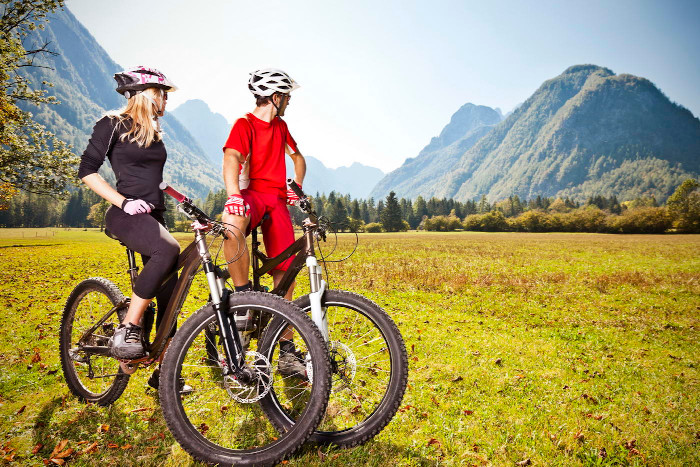

Будем работать только со следующими признаками:
* `season`: время года: 1 &mdash; зима, 2 &mdash; весна, 3 &mdash; лето, 4 &mdash; осень;
* `mnth`: месяц от 1 до 12;
* `holiday`: является ли текущий день праздничным;
* `weekday`: день недели от 0 до 6;
* `workingday`: является ли текущий день рабочим или выходным;
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман);
* `temp`: температура в Цельсиях;
* `atemp`: температура по ощущениям в Цельсиях;
* `hum`: влажность воздуха;
* `windspeed`: скорость ветра;
* `cnt`: количество арендованных велосипедов в текущий день.


---

Скачаем данные, разделим на обучающую и тестовую части в соотношении 4:1. 

In [3]:
data = pd.read_csv("day.csv")
data = data[["season", "mnth", "holiday", "weekday","workingday", "weathersit", "temp", "atemp",
                   "hum", "windspeed", "cnt"]]
data

season  mnth  holiday  weekday  workingday  weathersit      temp  \
0         1     1        0        6           0           2  0.344167   
1         1     1        0        0           0           2  0.363478   
2         1     1        0        1           1           1  0.196364   
3         1     1        0        2           1           1  0.200000   
4         1     1        0        3           1           1  0.226957   
..      ...   ...      ...      ...         ...         ...       ...   
726       1    12        0        4           1           2  0.254167   
727       1    12        0        5           1           2  0.253333   
728       1    12        0        6           0           2  0.253333   
729       1    12        0        0           0           1  0.255833   
730       1    12        0        1           1           2  0.215833   

        atemp       hum  windspeed   cnt  
0    0.363625  0.805833   0.160446   985  
1    0.353739  0.696087   0.248539   801  
2    0.189405  0.437273   0.248309  1349  
3    0.212122  0.590435   0.160296  1562  
4    0.229270  0.436957   0.186900  1600  
..        ...       ...        ...   ...  
726  0.226642  0.652917   0.350133  2114  
727  0.255046  0.590000   0.155471  3095  
728  0.242400  0.752917   0.124383  1341  
729  0.231700  0.483333   0.350754  1796  
730  0.223487  0.577500   0.154846  2729  

[731 rows x 11 columns]

In [51]:
dteach = data.sample(int(0.8*len(data.index)))  # обучающие
dtest = data.drop(dteach.index) # тестовые

#### 1. Визуальный анализ

Посмотрим по графикам, как *целевой признак зависит от остальных* и поймем характер этой зависимости.


Построим ящики с усами для анализа категориальных признаков.

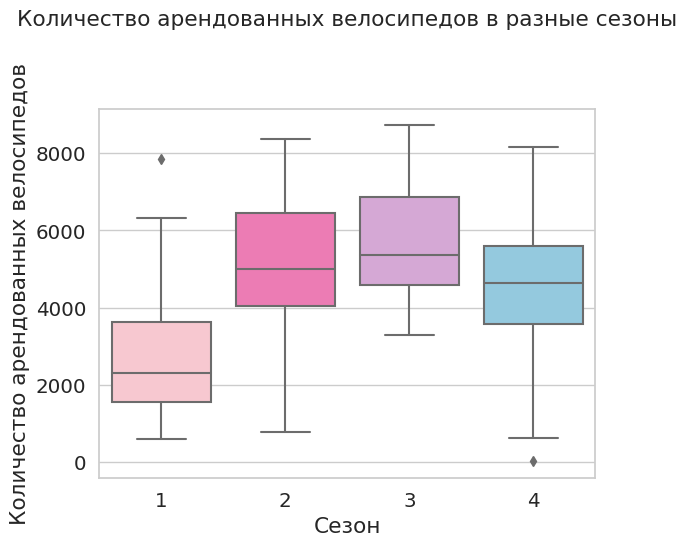

In [10]:
    colors = ['pink', 'hotpink', 'plum', 'skyblue']
    #plt.figure(figsize=(7, 3))
    sns.boxplot(data=dteach, x='season', y='cnt', palette=colors)
    plt.ylabel('Количество арендованных велосипедов')
    plt.xlabel('Сезон')
    plt.title('Количество арендованных велосипедов в разные сезоны', loc='center', pad=60)
    plt.show()

Видно, что в летний сезон велосипеды арендуют чаще. Меньше всего арендованных велосипедов зимой.

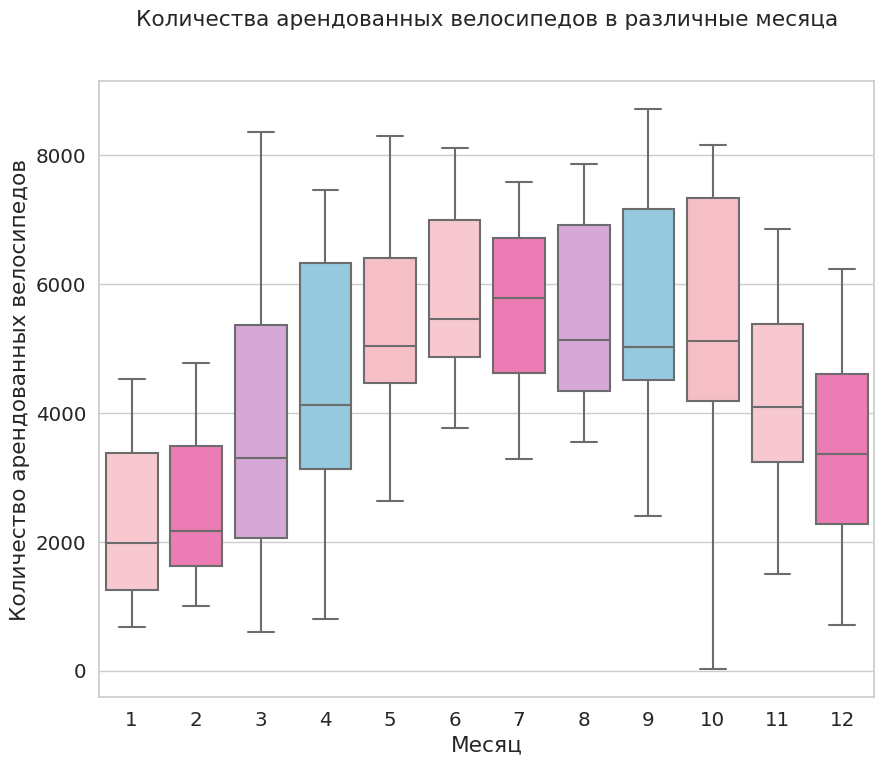

In [11]:
    colors = ['pink', 'hotpink', 'plum', 'skyblue', 'lightpink']
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=dteach, x='mnth', y='cnt', palette=colors)
    plt.ylabel('Количество арендованных велосипедов')
    plt.xlabel('Месяц')
    plt.title('Количества арендованных велосипедов в различные месяца', loc='center', pad=40)
    plt.show()

Тут также хорошо прослеживается, что в летние месяцы велосипеды пользуются натбольшей популярностью. Медианный пик кол-ва арендованных велосипедов приходится на июль.

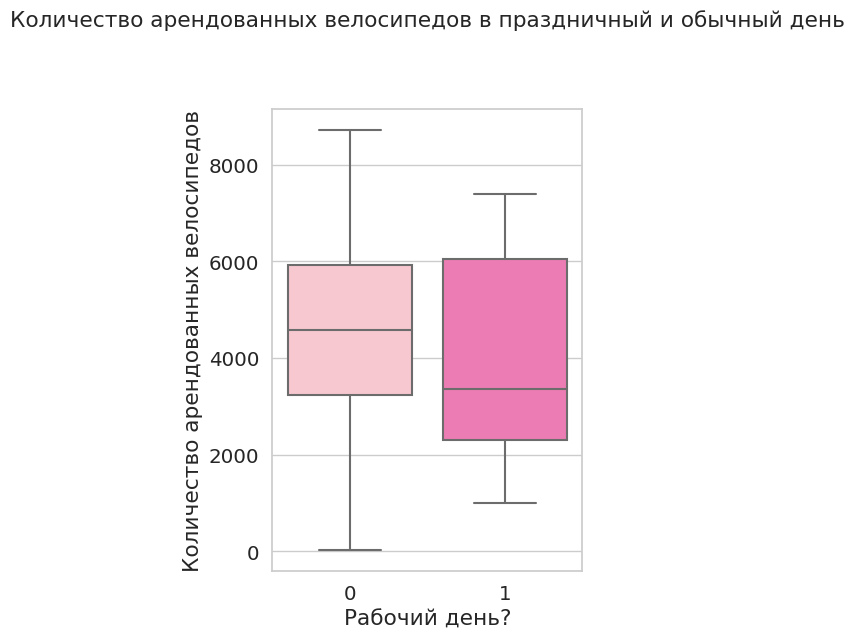

In [12]:
    colors = ['pink', 'hotpink', 'plum', 'skyblue', 'lightpink']
    plt.figure(figsize=(4, 6))
    sns.boxplot(data=dteach, x='holiday', y='cnt', palette=colors)
    plt.ylabel('Количество арендованных велосипедов')
    plt.xlabel('Рабочий день?')
    plt.title('Количество арендованных велосипедов в праздничный и обычный день', loc='center', pad=60)
    plt.show()

Если оценивать по медианным значениям, то заметно, что в праздники люди чаще пользуются услугами аренды, но при этом верхнии границы ящика совпадают. Кажется, праздники хочется объединить с выходными. Логично предположить, что в рабочие дни арендованных велосипедов будет меньше, чем в свободный от работы.

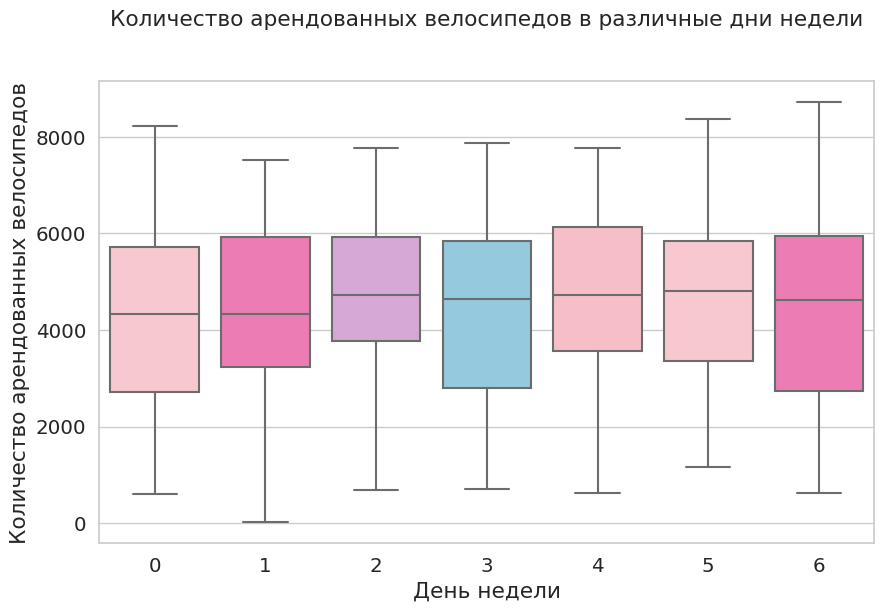

In [15]:
    colors = ['pink', 'hotpink', 'plum', 'skyblue', 'lightpink']
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=dteach, x='weekday', y='cnt', palette=colors)
    plt.ylabel('Количество арендованных велосипедов')
    plt.xlabel('День недели')
    plt.title('Количество арендованных велосипедов в различные дни недели', loc='center', pad=40)
    plt.show()

Из графика видно, что день недели на медианное значение не влияет.

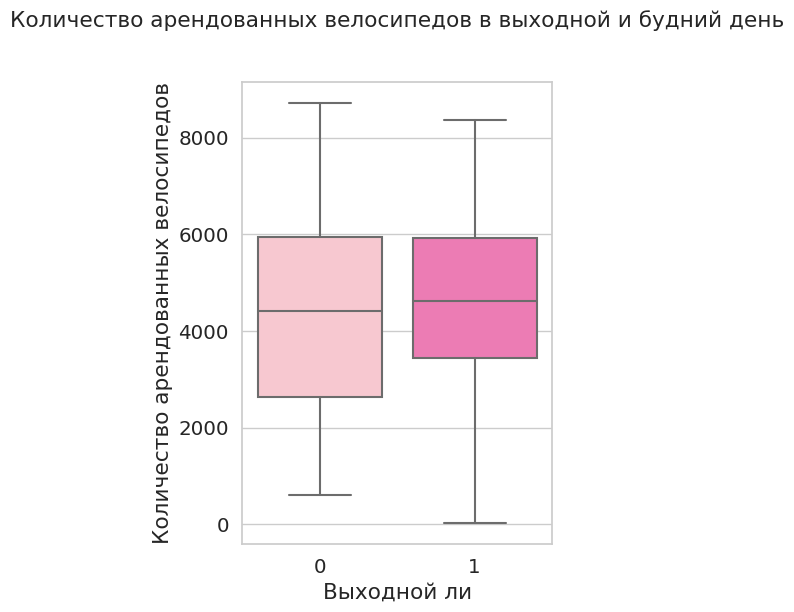

In [16]:
    colors = ['pink', 'hotpink', 'plum', 'skyblue', 'lightpink']
    plt.figure(figsize=(4, 6))
    sns.boxplot(data=dteach, x='workingday', y='cnt', palette=colors)
    plt.ylabel('Количество арендованных велосипедов')
    plt.xlabel('Выходной ли')
    plt.title('Количество арендованных велосипедов в выходной и будний день', loc='center', pad=40)
    plt.show()

График показал, что медианные значения в будни и выходной практически совпадают, но при это, если посмотреть на границы ящика, видно, что в выходной нижний порог выше.

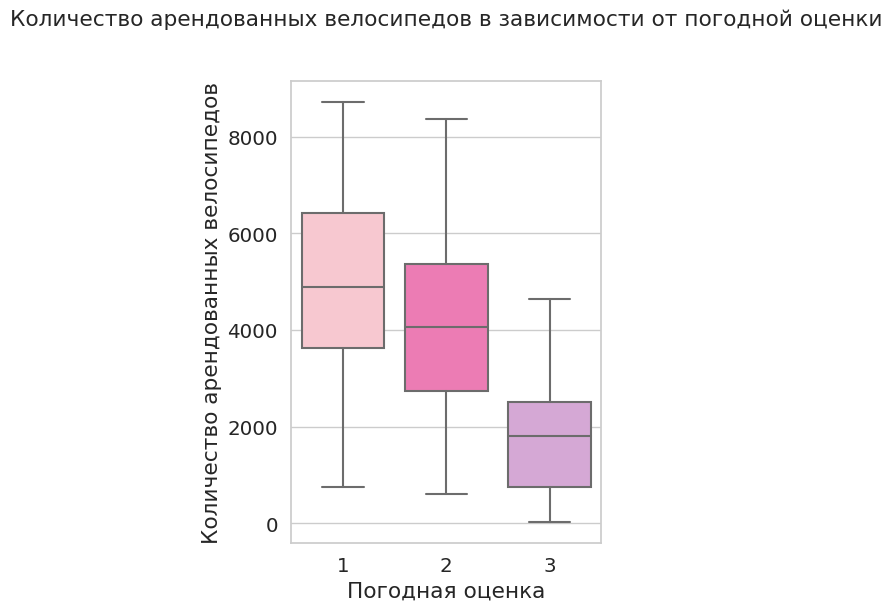

In [17]:
    colors = ['pink', 'hotpink', 'plum', 'skyblue', 'lightpink']
    plt.figure(figsize=(4, 6))
    sns.boxplot(data=dteach, x='weathersit', y='cnt', palette=colors)
    plt.ylabel('Количество арендованных велосипедов')
    plt.xlabel('Погодная оценка')
    plt.title('Количество арендованных велосипедов в зависимости от погодной оценки', loc='center', pad=40)
    plt.show()

Данные подтверждают, что погода сильно влияет на количество арендованных велосипедов. С ухудшением погодных условий уменьшается кол-во арендаторов.

Для вещественных признаков построим точечные диаграммы.
Нанесем фактическую температуру и ощущаемую температуру на один график.

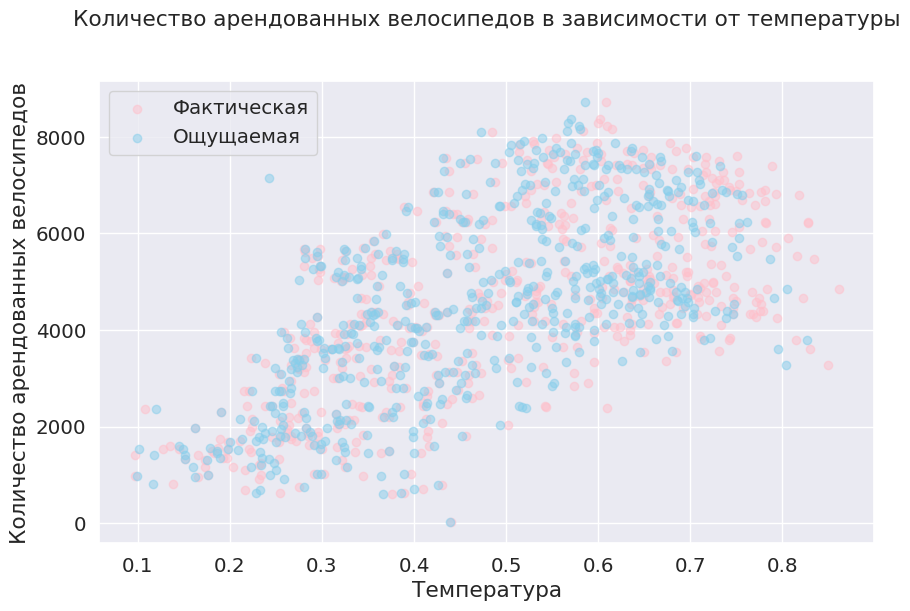

In [18]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
plt.scatter(dteach['temp'], dteach['cnt'], alpha=0.5, c='pink')
plt.scatter(dteach['atemp'], dteach['cnt'], alpha=0.5, c='skyblue')
plt.legend(["Фактическая", "Ощущаемая"],loc='upper left')
plt.ylabel('Количество арендованных велосипедов')
plt.xlabel('Температура')
plt.title('Количество арендованных велосипедов в зависимости от температуры', loc='center', pad=40)

plt.show()

Из графика видно, что количество арендованных велосипедов линейно возрастает при возрастание температуры. Также видно, что фактическая и ощущаемая температура практически не отличаются - воспользуемя этим фактом позже.

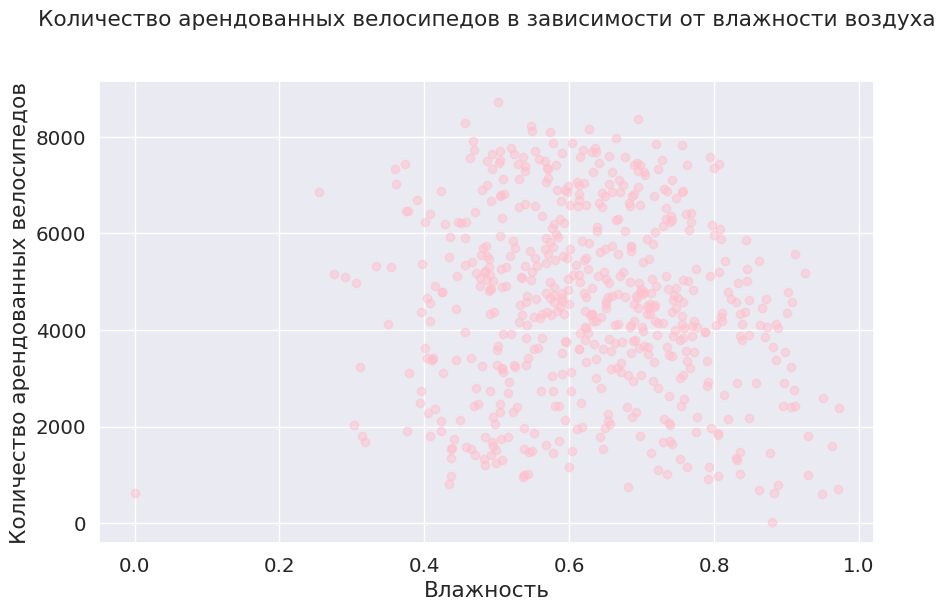

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(dteach['hum'], dteach['cnt'], alpha=0.5, c='pink')
plt.ylabel('Количество арендованных велосипедов')
plt.xlabel('Влажность')
plt.title('Количество арендованных велосипедов в зависимости от влажности воздуха', loc='center', pad=40)

plt.show()

Из графика не просматривается зависимость арендованных велосипедов от влажности воздуха. Однако, мы проверили лишь линейную зависимость, часто можно найти сложную зависимость, используя нелинейные функции (log и I - не позволили увидеть что-то хорошее). Посмотрим на квадратичную зависимость.

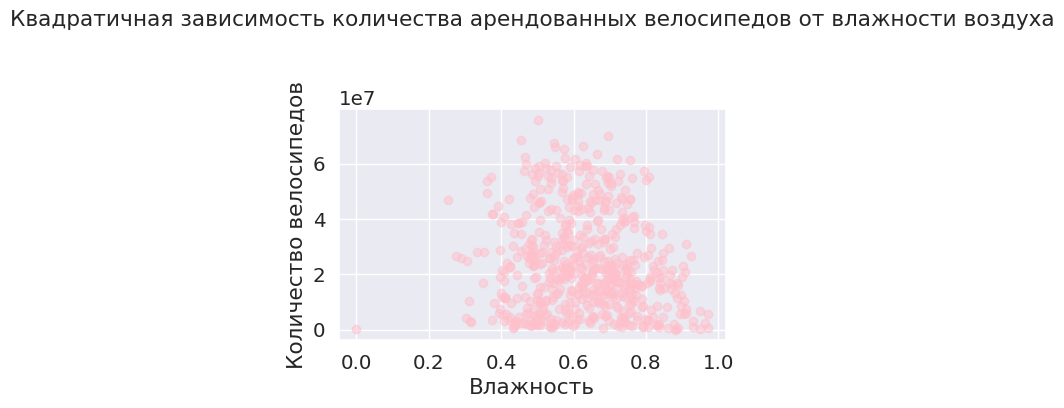

In [20]:
plt.figure(figsize=(5, 3))
plt.scatter(dteach['hum'], dteach['cnt']**2, alpha=0.5, c='pink')
plt.ylabel('Количество велосипедов')
plt.xlabel('Влажность')
plt.title('Квадратичная зависимость количества арендованных велосипедов от влажности воздуха', loc='center', pad=60)
plt.show()

Все еще не очень хорошо, но можно увидеть, что данные попадают в своеобразный треугольник - можно объяснить тем, что часто очень высокая влажность соответствует дождю / туману - в такую погоду должно быть меньше желающих прокатиться на велосипеде. Также на полученном графике хорошо видны выбросы - крайние точки справа.

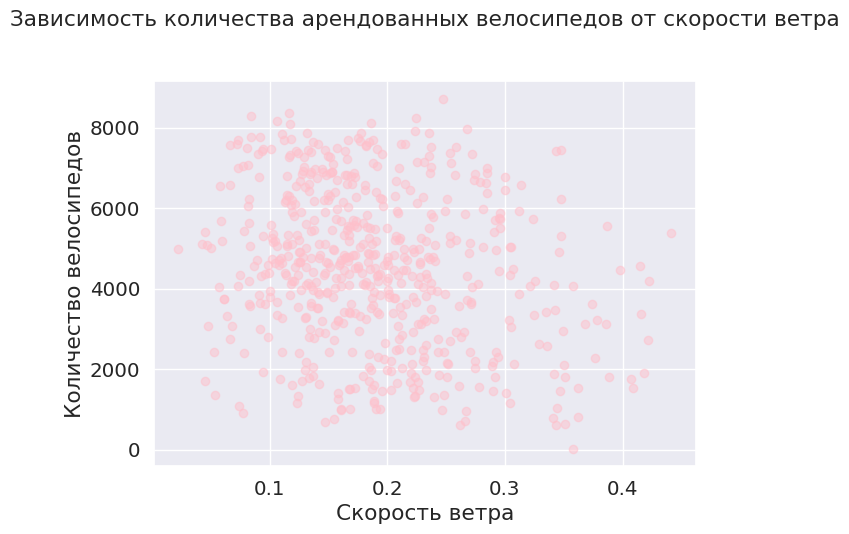

In [21]:
plt.figure(figsize=(7, 5))
plt.scatter(dteach['windspeed'], dteach['cnt'], alpha=0.5, c='pink')
plt.ylabel('Количество велосипедов')
plt.xlabel('Скорость ветра')
plt.title('Зависимость количества арендованных велосипедов от скорости ветра', loc='center', pad=40)
plt.show()

Тут аналогично предыдущему пункту, можно заметить, что точки попадают в границы треугольника - чтобы лучше это проследить рассмотрим квадратичную зависимость.

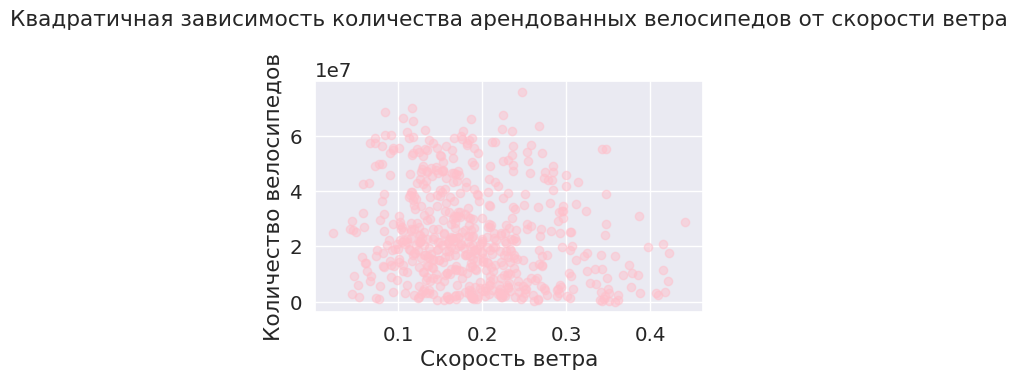

In [22]:
plt.figure(figsize=(5, 3))
plt.scatter(dteach['windspeed'], dteach['cnt']**2, alpha=0.5, c='pink')
plt.ylabel('Количество велосипедов')
plt.xlabel('Скорость ветра')
plt.title('Квадратичная зависимость количества арендованных велосипедов от скорости ветра', loc='center', pad=40)
plt.show()

График позволяет увидеть, что в очень ветренную погоду редко арендуют большое количество велосипедов.

Посмотрим на зависимости между признаками.

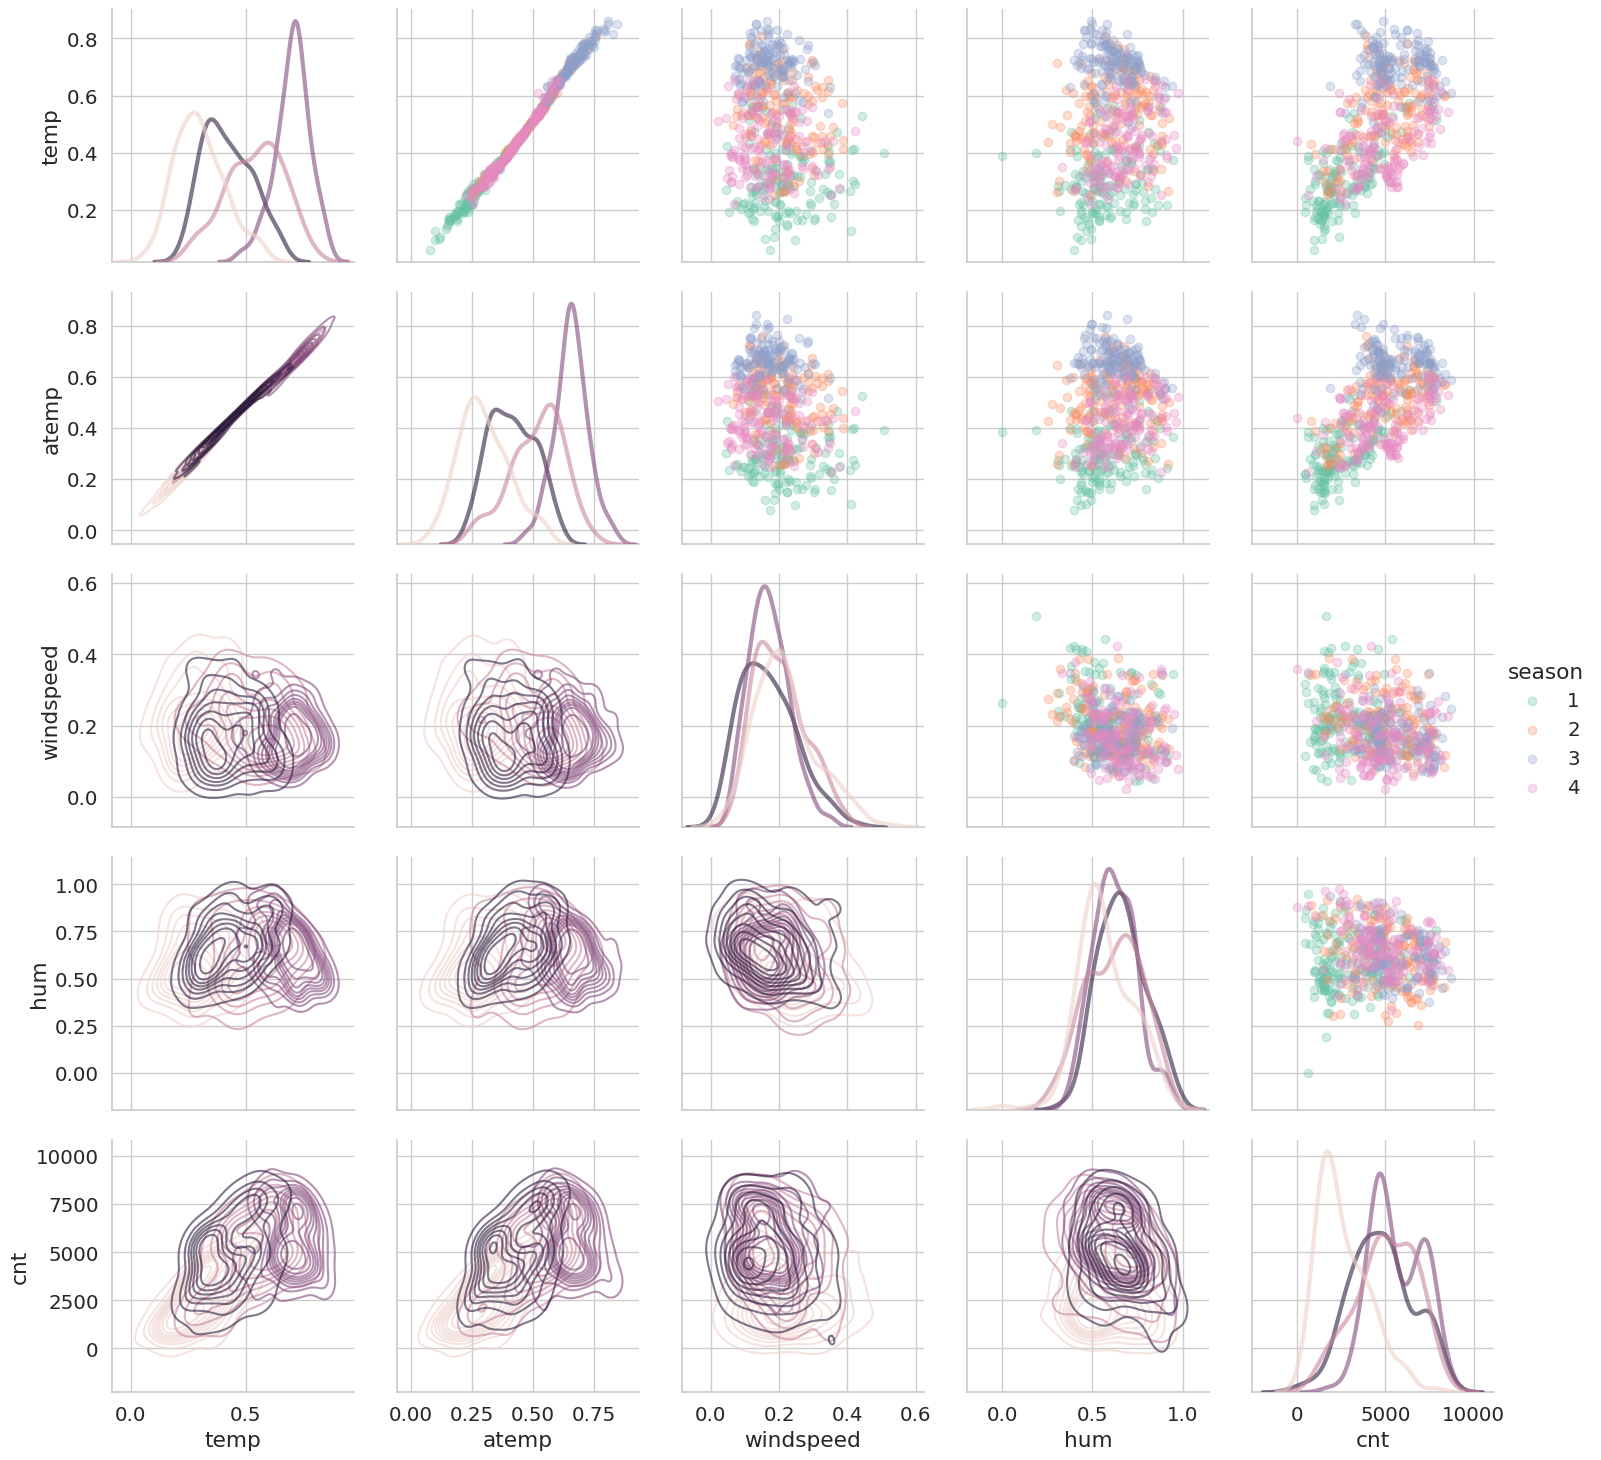

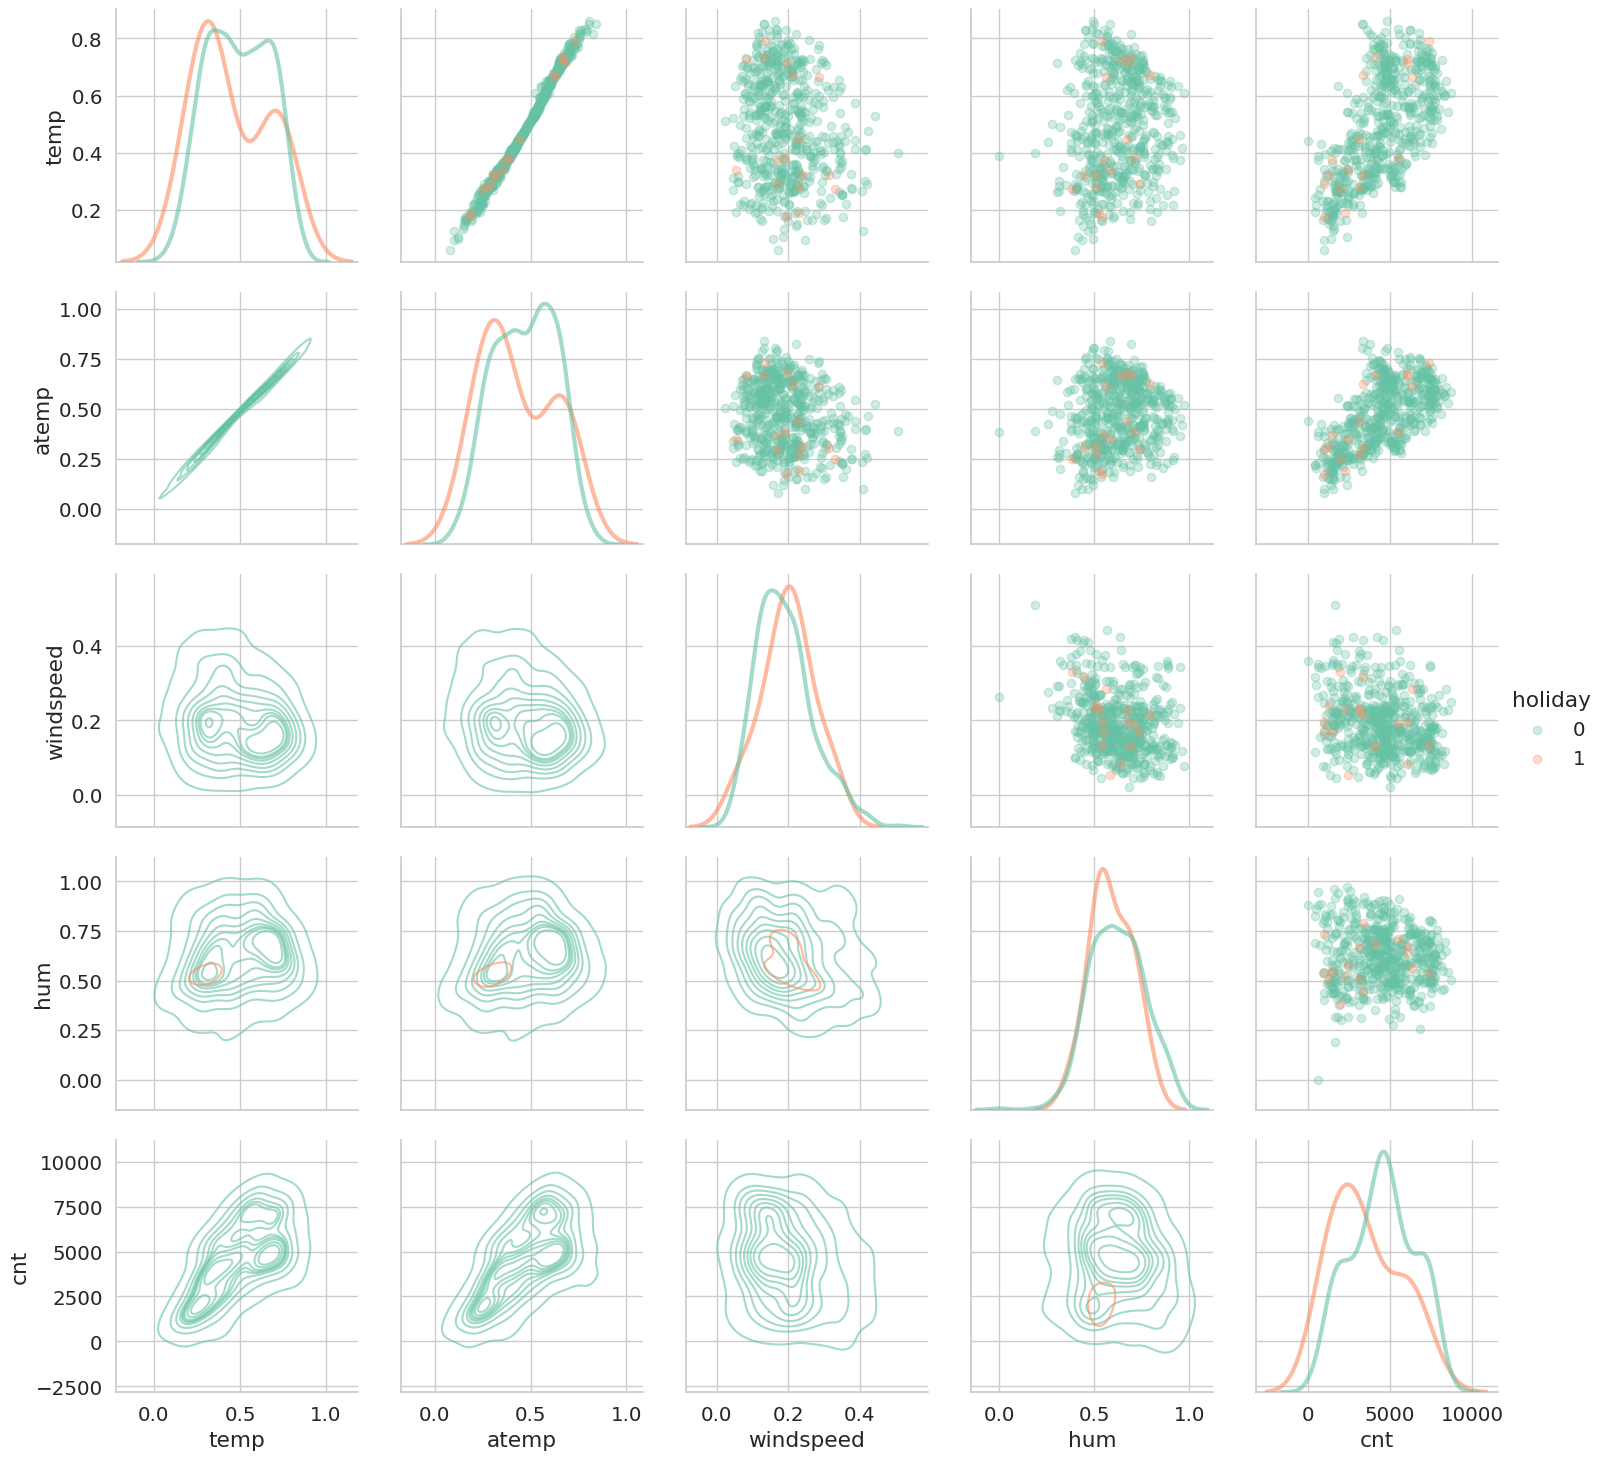

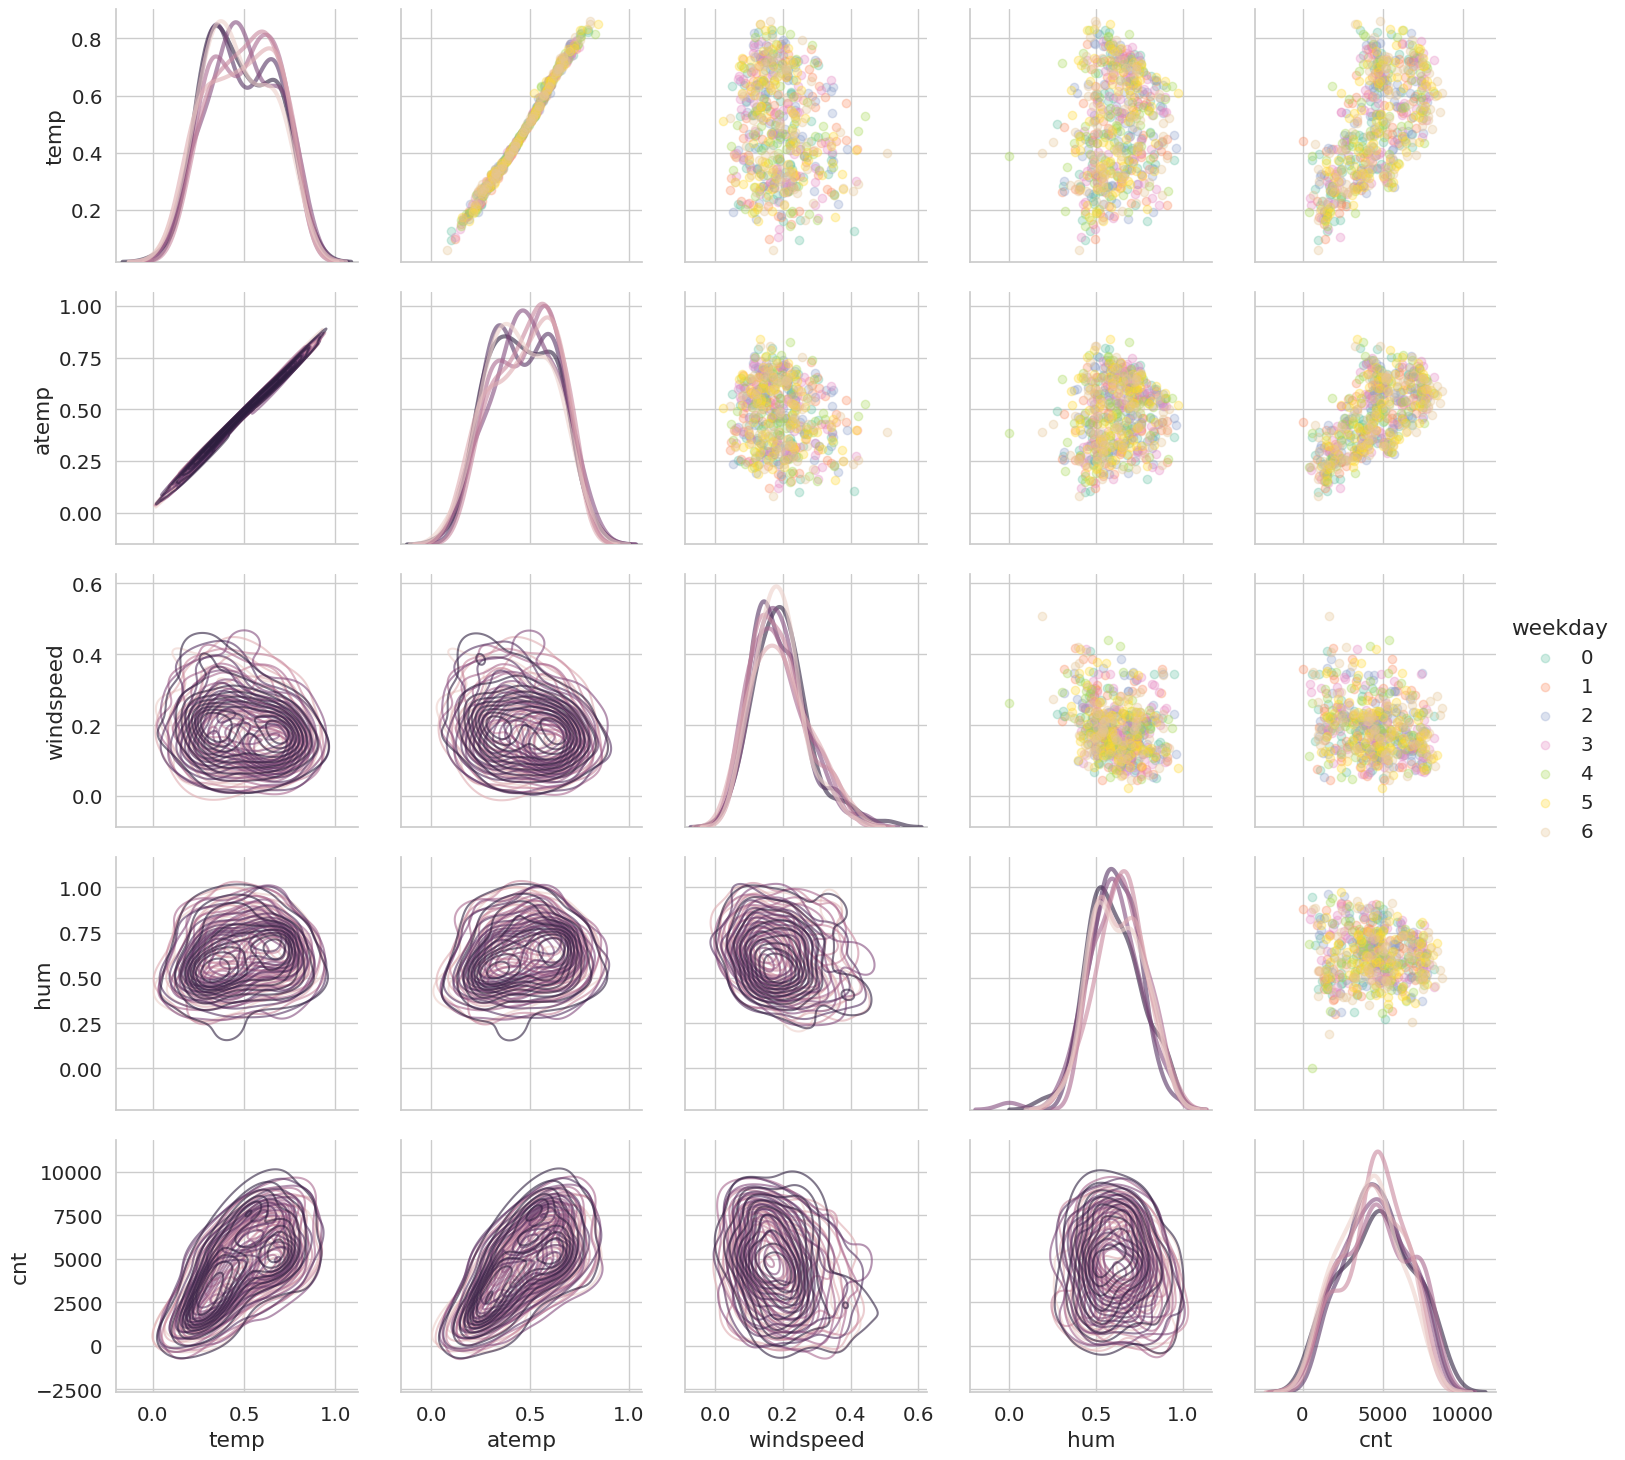

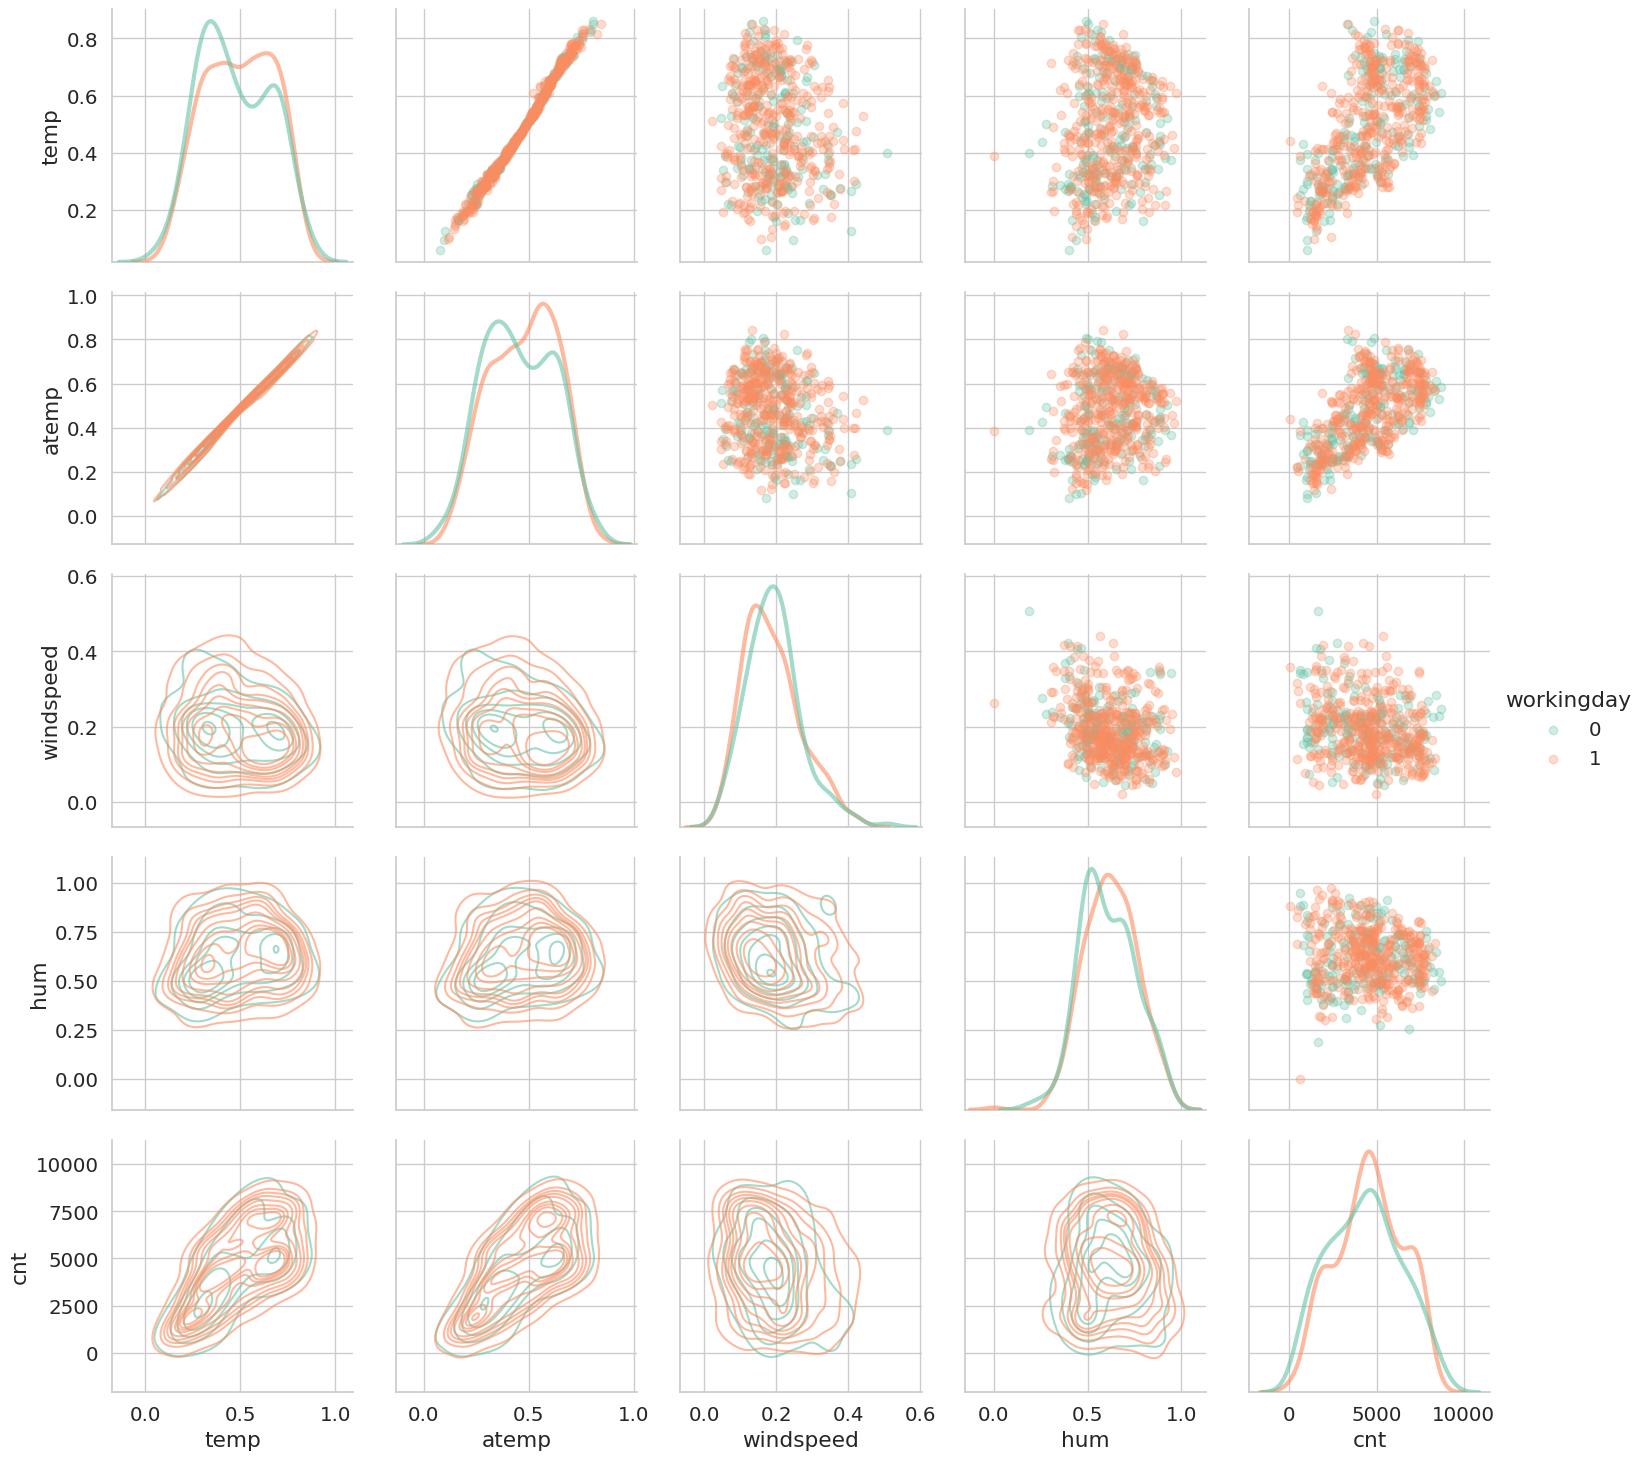

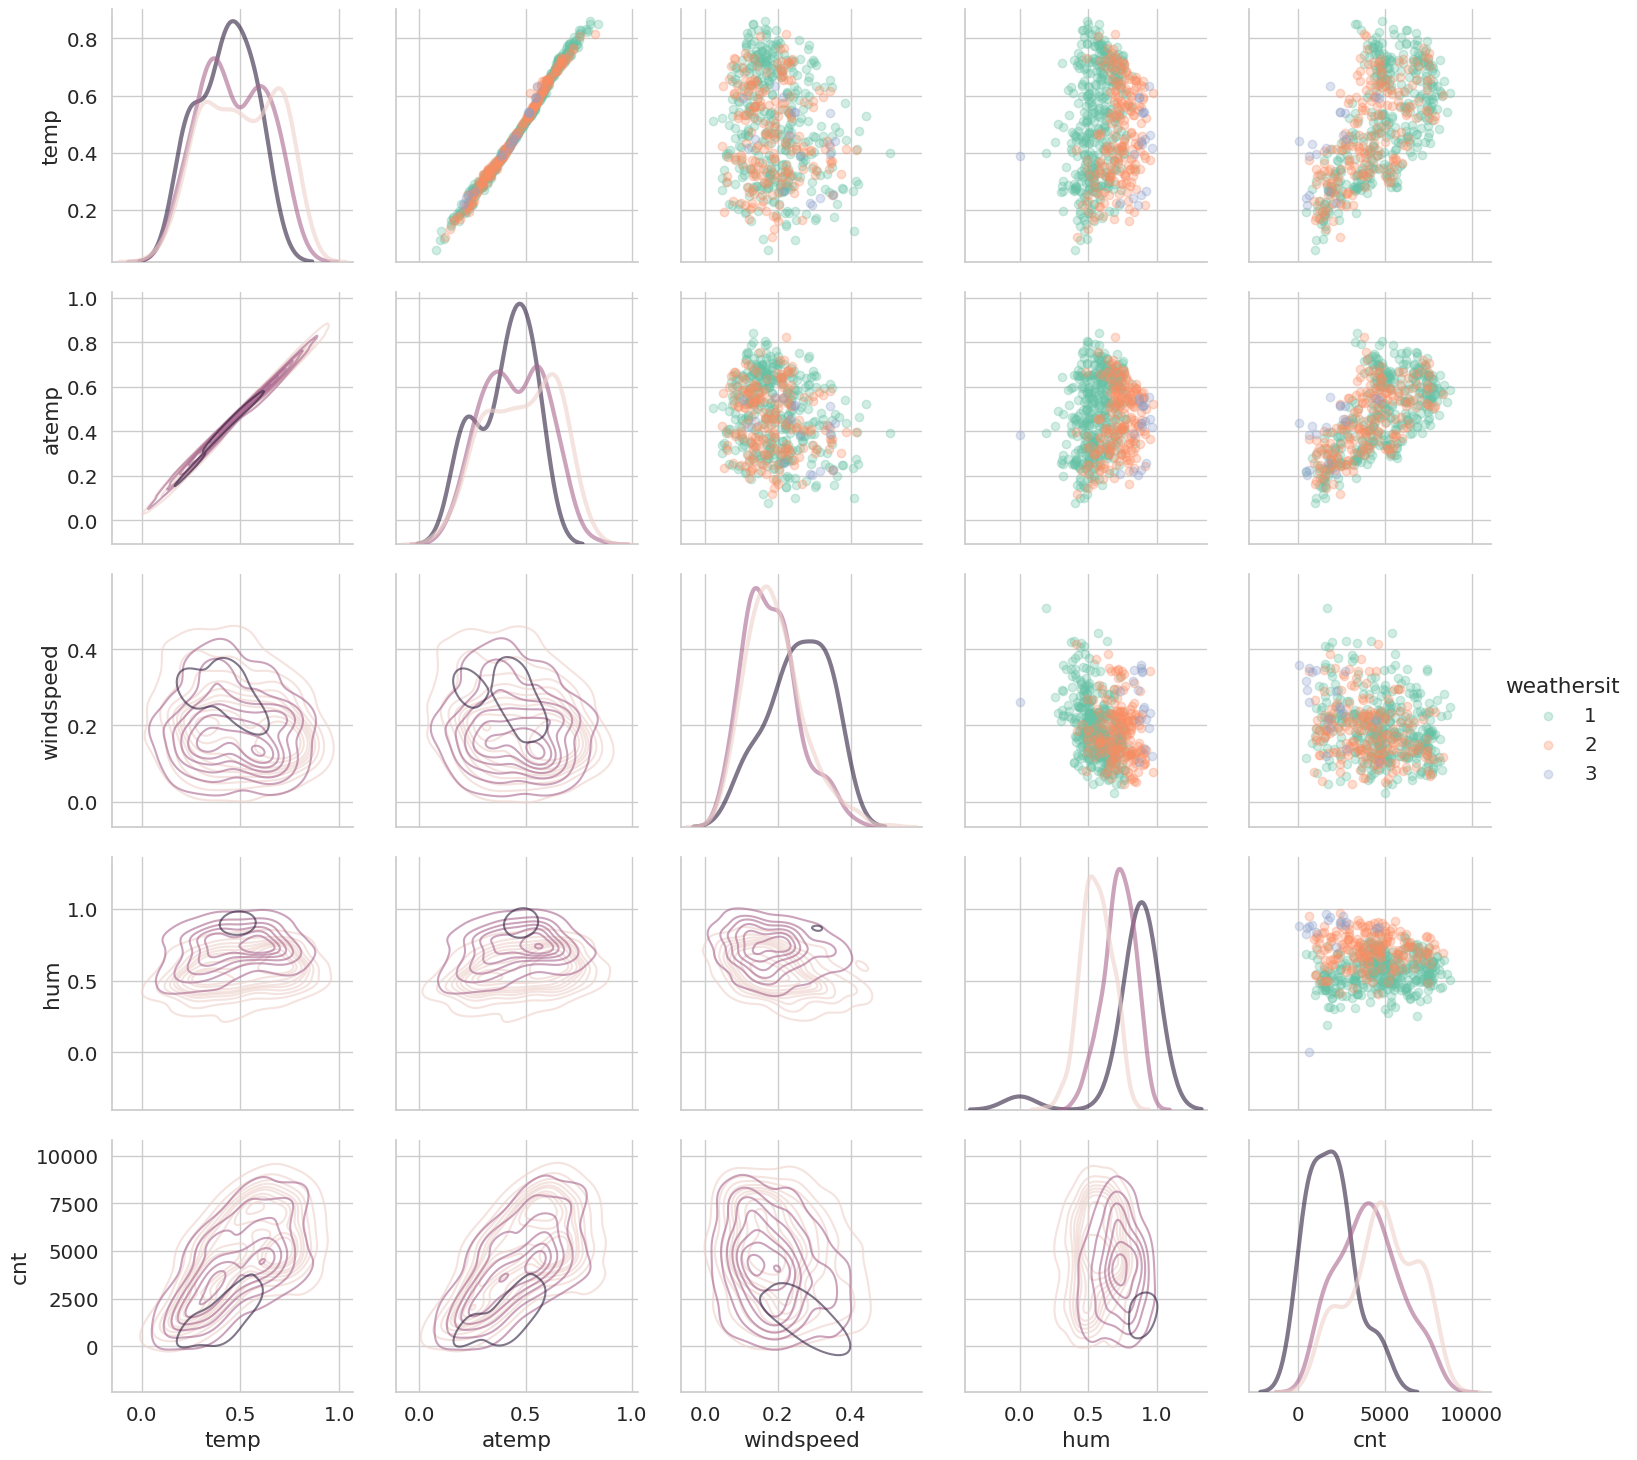

In [52]:
sns.set_style('whitegrid')
for hue in ['season', 'holiday', 'weekday', 'workingday', 'weathersit']:
    g = sns.PairGrid(dteach[['temp', 'atemp','windspeed', 'hum', 'cnt', hue]], 
                     hue=hue, diag_sharey=False, height=3)
    
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6, 
               common_norm=False)  # каждая плотность по отдельности должна давать 1 при интегрировании
    
    g.add_legend()

Тут еще раз можно убедиться, что фактическая и ощущаемая температура практически свопадают. Данные графики подтверждают все, что было сказано выше. Также можно заметить, что на "хорошесть" погоды влияет влажность, температура и скорость ветра. Низкую темперутру / сильный ветер / высокую влажность - считают плохой погодой, соответсвенно, в эти дни мало клиентов.

**Выводы по графикам:**

Из графиков удалось проследить, как различные признаки влияют на количество арендованных велосипедов: в теплые месяцы года арендаторов намного больше, чем в зимний сезон, "хорошесть" погоды также достаточно сильно влияет на "арендуемость" велосипедов, удалось увидеть линейную зависимость исследуемого признака от температуры (растет температура - растет кол-во клиентов). Линейную зависимость от влажности и скорости ветра не получилось обнаружить, при рассмотрении нелинейных функций от этих признаков log и  I не показали ничего информативного. Квадратичная функция позволила чуть лучше взглянуть на влияние этих признаков: при сильном ветре редко арендуют большое количество велосипедов - аналогично при высокой влажности (которая, скорее всего соответствует дождливой погоде). На многих графиков можно было увидеть выбросы (точки вдали от всех) - это было видно на ящиках с усами и в последних графиках, для которых строилась квадратичная зависимость.

#### 2. Подготовка данных


**Процедура предобработки данных:**

**a).**  как заметили раньше, температура и ощущаемая температура практически совпадают - уберем ощущуаемую температуру - избавимся от лишних данных. 

**б).** Избавимся от выбросов (посчитаем первый и третий квантиль для вещественных признако, оставим данные, которые лежат в промежутке между квантилями и те, которые удалены от них на расстаяние меньше расстояния между квантилями).

**в).** Применем OneHotEncoding к категориальным признакам (это уберет приоритетные отношения между столбцами)


Реализуем данную процедуру.

In [25]:
categorial_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'] # категориальные признаки
real_features = ['temp', 'hum', 'windspeed']  # вещественные признаки
target_feature = 'cnt'  # целевой признак

Удалим колонку - ощущаемая температура

In [53]:
dteach = dteach.drop(columns=["atemp"])

Напишем функцию, удаляющая выбросы по представленному выше алгоритму

In [30]:
import typing as tp
import scipy.stats as sps

def delkak(df: pd.DataFrame) -> pd.DataFrame:
    a1 = df.windspeed.quantile([0.25,0.75]).iloc[0]
    a2 = df.windspeed.quantile([0.25,0.75]).iloc[1]
    delt = (a2 - a1) 
    df = df[df['windspeed'] < a2 + delt]
    df = df[df['windspeed'] > a1 - delt]
    
    a1 = df.hum.quantile([0.25,0.75]).iloc[0]
    a2 = df.hum.quantile([0.25,0.75]).iloc[1]
    delt = (a2 - a1) 
    df = df[df['hum'] < a2 + delt]
    df = df[df['hum'] > a1 - delt]
    
    a1 = df.temp.quantile([0.25,0.75]).iloc[0]
    a2 = df.temp.quantile([0.25,0.75]).iloc[1]
    delt = (a2 - a1) 
    df = df[df['temp'] < a2 + delt]
    df = df[df['temp'] > a1 - delt]
    
    return df

Применем ее:

In [54]:
print(len(dteach))
train = delkak(dteach)
print(len(train))

584
531


Превратим категориальные признаки в столбцы из 0 и 1

In [55]:
encoder = OneHotEncoder(drop='first', sparse_output=False)  # объявляем модель
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

Соединим вместе вещественные признаки и закодированные категориальные

In [56]:
X_train = np.hstack([train[real_features], train_cat])
X_train

array([[0.182222, 0.577778, 0.195683, ..., 1.      , 0.      , 0.      ],
       [0.203478, 0.793043, 0.1233  , ..., 1.      , 1.      , 0.      ],
       [0.730833, 0.66875 , 0.153617, ..., 1.      , 0.      , 0.      ],
       ...,
       [0.420833, 0.659167, 0.1275  , ..., 0.      , 0.      , 0.      ],
       [0.464167, 0.57    , 0.171638, ..., 1.      , 1.      , 0.      ],
       [0.169091, 0.686364, 0.122132, ..., 1.      , 1.      , 0.      ]])

#### 3. Обучение модели и ее анализ

Обучим линейную регрессию из `sklearn` на полученных данных 

In [34]:
model = LinearRegression(fit_intercept=True)  # объявляем модель
model.fit(X_train, train[target_feature])  # обучаем

LinearRegression()

Посмотрим на результат обучения. Оценки коэффициентов перед признаками

In [35]:
model.coef_

array([ 6696.10085002, -3615.77612063, -3453.14104825,  1087.07505467,
         656.6771385 ,  1518.61695786,   151.59850402,   385.88895106,
         -90.34634686,    54.86733681,  -620.91442026,  -720.97443001,
        -389.05741451,   907.04295458,   393.86220586,  -136.13928628,
          -9.7176307 ,  -448.15600073,   -34.78665027,   -34.9033351 ,
         -58.52914024,  -106.86936577,    42.38275886,   429.63267507,
         255.45026821,  -182.50264106, -1111.02405771])

Оценка свободного коэффициента

In [36]:
model.intercept_

3270.566289794465

Посчитаем ошибку предсказания на тестовой выборке по метрикам RMSE, MAE, MAPE.

Избавимся от выбросов в тестовой выборке

In [37]:
test = delkak(dtest)

In [38]:
# Кодируем категориальные признаки с помощью метода transform обученного ранее кодировщика
test_cat = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_cat])

Выполним предсказание построенной ранее моделью с помощью метода predict

In [39]:
test_preds = model.predict(X_test)

Считаем RMSE

In [40]:
np.sqrt(((test[target_feature] - test_preds) ** 2).mean())

1151.6870548117156

То есть в среднем отклонения предсказания величины кол-ва арендованных велосипедов имеют порядок 1200 условных единиц. 

Считаем MAE

In [41]:
metrics.mean_absolute_error(test[target_feature], test_preds)

994.7985410648926

Считаем MAPE

In [42]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [43]:
mean_absolute_percentage_error(test[target_feature], test_preds)

24.913655720040335

Процент ошибки оказался около 25% - это не очень хорошо в реальной задаче, но мы строим очень простую модель.


Попробуем посчитать оценку коэффициентов с помощью формулы

Чтобы формула работала, нам нужно чтобы не было линейно зависимых признаков (мы уже сделали предобработку данных выше). Получим матрицу коэффициентов.

In [57]:
X_train_intercept = np.hstack([X_train, np.ones((len(X_train), 1))])
theta = np.linalg.inv((X_train_intercept.T @ X_train_intercept)) @ \
        X_train_intercept.T @ train[target_feature] 
theta

array([ 6627.42534326, -4645.8952649 , -4925.93703854,  1837.59399425,
         827.00342693,  2058.41561003,    29.16662945,   446.66259524,
        -620.1748626 ,  -391.41468038, -1221.68807386, -1063.00275275,
        -180.32879105,   834.93888117,  -147.92528237,  -723.95462386,
        -357.56081436,  -146.85968912,  1350.80699721,  4054.88036143,
        1277.66403752,   533.33765411,  4442.57647376,   527.38559772,
         331.24168915,  -173.04959262,  -823.03089845,  3153.54566255])

Посчитаем ошибку предсказания.

In [58]:
X_test_intercept = np.hstack([X_test, np.ones((len(X_test), 1))])
tcoef = X_test_intercept @ theta

RMSE:

In [59]:
metrics.mean_squared_error(test[target_feature], tcoef) ** 0.5

2211.0710784271087

MAE:

In [60]:
metrics.mean_absolute_error(test[target_feature], tcoef)

1710.0532261762044

MAPE:

In [61]:
mean_absolute_percentage_error(test[target_feature], tcoef)

46.8552942322588

**Выводы:**

Регрессия, полученная с помощью sklearn на тестовых данных справилась намного лучше, чем аналитический подсчет. Например, при использовании sklearn MAPE = 25%, а при аналитическом решении около 50%. Это можно объяснить, тем, что в работе использовались самые простые методы предобработки данных.

Реализуем класс для работы с моделью ridge-регрессии, используя явную формулу 

In [62]:
class RidgeRegression:
    def __init__(self, lambd=0.1, fit_intercept=True):
        '''
        Инициализация модели.
        
        Аргументы:
        lambd -- параметр регуляризации.
        fit_intercept -- добавить ли константный признак.
        '''
        
        self.lambd = lambd
        self.fit_intercept = fit_intercept
        
        
    def fit(self, X, Y):
        '''
        Обучение модели ridge-регрессии.
        
        Аргументы:
        X -- numpy-матрица объект-признак размера (n, d);
        Y -- numpy-вектор значений целевого признака размера (n,).
        '''
        
        # Посчитайте оценки коэффициентов и, возможно, 
        # еще что-то, что пригодится в predict.
        
        X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
        self.k = np.linalg.inv(X.T @ X + np.eye(len(X.T)) * self.lambd) @ X.T @ Y

        
        return self
    
    
    def predict(self, X):
        '''
        Вычисление предсказаний.
        
        Аргументы:
        X -- numpy-матрица объект-признак размера (n, d);
        
        Возвращает:
        predictions -- предсказания в виде numpy-вектора размера (n,).
        '''
        
        # Посчитайте предсказания
        X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
        predictions = X @ self.k
        
        return predictions

Разделим данные на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1. 

In [82]:
dteach = data.sample(int(0.6*len(data.index)))  # обучающие
temp = data.drop(dteach.index) 
dtest = temp.sample(int(0.5*len(temp.index)))  # тестовые
dval = temp.drop(dtest.index)  # Валидационные

Выполним необходимые преобразования признаков. 
Удалим, ненужные данные

In [83]:
dteach = dteach.drop(columns=["atemp"])

Избавимся от выбросов

In [84]:
print(len(dteach))
train = delkak(dteach)
print(len(train))

438
403


In [85]:
print(len(dval))
dval = delkak(dval)
print(len(dval))

147
133


In [86]:
print(len(dtest))
dtest = delkak(dtest)
print(len(dtest))

146
134


Повторяем пункты из 2 задания и выполним стандартизацию признаков, чтобы не было приоритетных признаков.

In [87]:
scaler = StandardScaler()

In [88]:
encoder = OneHotEncoder(drop='first', sparse_output=False)  # объявляем модель
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем

X_train = np.hstack([train[real_features], train_cat])

X_train = scaler.fit_transform(X_train)  # Маштабируем признаки

In [89]:
validate_cat = encoder.transform(dval[categorial_features])

X_val = np.hstack([dval[real_features], validate_cat])
X_val = scaler.transform(X_val)  # Маштабируем признаки

In [90]:
test_cat = encoder.transform(dtest[categorial_features])

X_test = np.hstack([dtest[real_features], test_cat])
X_test = scaler.transform(X_test)  # Маштабируем признаки

Определим сетку значений гиперпараметра $\lambda$ и обучим для каждого значения сетки модель ridge-регрессии.

In [296]:
grid = np.logspace(-3, 1.5, 100)
ans = []

for lambd in grid:
    mod = RidgeRegression(lambd)
    mod.fit(X_train, train[target_feature])
    ans.append(mod)

Для каждой из них посчитаем ошибку по метрикам RMSE, MAE, MAPE по обучающей и валидационной выборкам. 

Сохраним все полученные результаты в массивах

In [201]:
trmse = []
vrmse = []
tmae = []
vmae = []
tmape = []
vmape = []

for model in ans:
    t1 = model.predict(X_train)
    v1 = model.predict(X_val)
    trmse.append(metrics.mean_squared_error(train[target_feature], t1) ** 0.5)
    vrmse.append(metrics.mean_squared_error(dval[target_feature], v1) ** 0.5)
    tmae.append(metrics.mean_absolute_error(train[target_feature], t1))
    vmae.append(metrics.mean_absolute_error(dval[target_feature], v1))
    tmape.append(mean_absolute_percentage_error(train[target_feature], t1))
    vmape.append(mean_absolute_percentage_error(dval[target_feature], v1)) 

Для каждой метрики построим графики зависимости значений метрики от значения гиперпараметра. Сравним поведение значений метрик для обучающей и валидационной выборок.

Построим графики в обычном и логарифметическом маштабах (тк мы взяли сетку в логарифметическом маштабе) - скорее всего, так получится нагляднее.

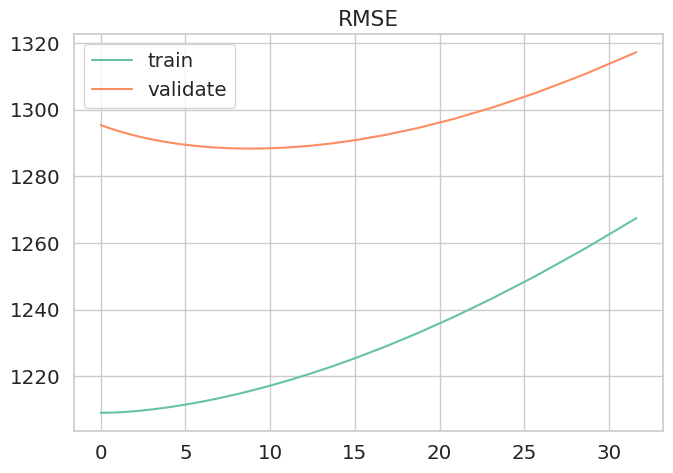

In [116]:
fig = plt.figure(figsize=(7, 5))
plt.title("RMSE")

#ax = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)

plt.plot(grid, trmse)
plt.plot(grid, vrmse)

#ax2.loglog(grid, trmse)
#ax2.loglog(grid, vrmse)
plt.legend(["train", "validate"])

fig.tight_layout()

Теперь в логарифмическом маштабе:

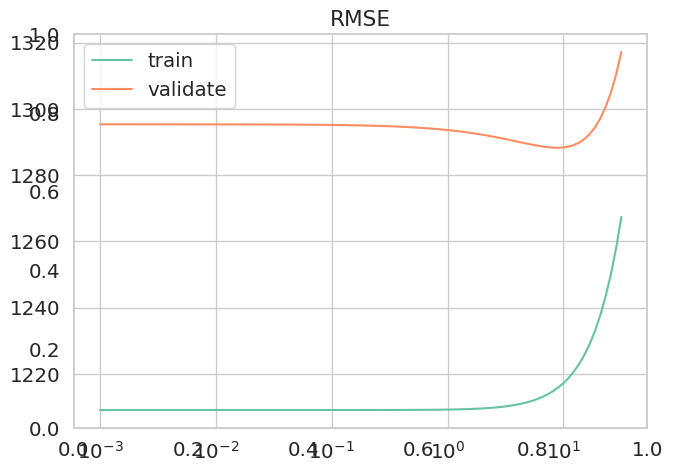

In [122]:
fig = plt.figure(figsize=(7, 5))
plt.title("RMSE")

ax = fig.add_subplot()
#ax = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)

ax.plot(grid, trmse)
ax.plot(grid, vrmse)
ax.set_xscale('log')

#plt.loglog(grid, trmse)
#plt.loglog(grid, vrmse)
plt.legend(["train", "validate"])

fig.tight_layout()

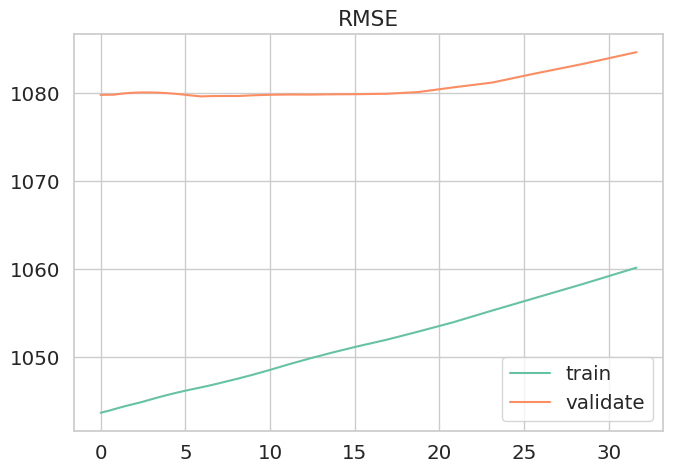

In [123]:
fig = plt.figure(figsize=(7, 5))
plt.title("RMSE")

#ax = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)

plt.plot(grid, tmae)
plt.plot(grid, vmae)

#ax2.loglog(grid, trmse)
#ax2.loglog(grid, vrmse)
plt.legend(["train", "validate"])

fig.tight_layout()

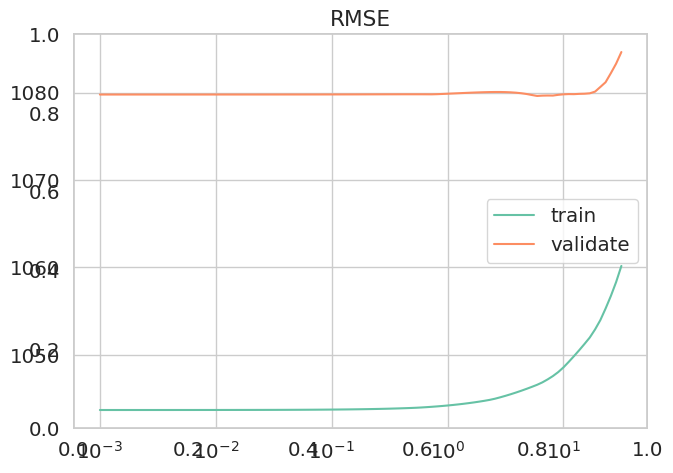

In [124]:
fig = plt.figure(figsize=(7, 5))
plt.title("RMSE")

ax = fig.add_subplot()
#ax = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)

ax.plot(grid, tmae)
ax.plot(grid, vmae)
ax.set_xscale('log')

#plt.loglog(grid, trmse)
#plt.loglog(grid, vrmse)
plt.legend(["train", "validate"])

fig.tight_layout()

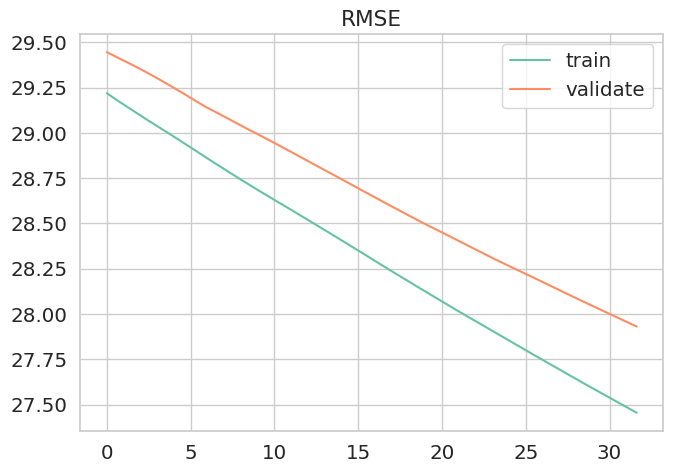

In [125]:
fig = plt.figure(figsize=(7, 5))
plt.title("RMSE")

#ax = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)

plt.plot(grid, tmape)
plt.plot(grid, vmape)

#ax2.loglog(grid, trmse)
#ax2.loglog(grid, vrmse)
plt.legend(["train", "validate"])

fig.tight_layout()

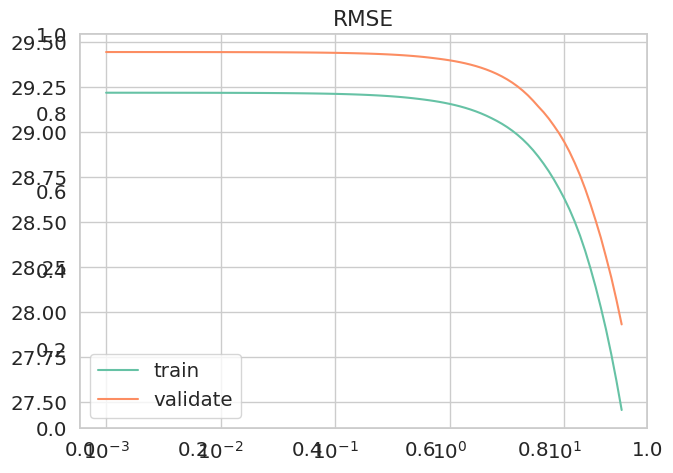

In [126]:
fig = plt.figure(figsize=(7, 5))
plt.title("RMSE")

ax = fig.add_subplot()
#ax = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)

ax.plot(grid, tmape)
ax.plot(grid, vmape)
ax.set_xscale('log')

#plt.loglog(grid, trmse)
#plt.loglog(grid, vrmse)
plt.legend(["train", "validate"])

fig.tight_layout()

Из графиков хорошо видно, что модель на обучающихся данных получает ошибку намного ниже.

Построим также на одном графике кривые зависимости значений оценок коэффициентов от значений гиперпараметра.

Для наглядности прменим логарифметическую сетку (ее шаг), (это нужно, чтобы было видно, что коэффициенты сходятся к нулю)

In [304]:
grid = np.logspace(-3, 2.5, 100)

In [305]:
col = {
    "temp": [0],
    "hum": [1],
    "windspeed": [2],
    "season": [3, 4, 5],
    "mnth": [6,7,8,9,10,11,12,13,14,15,16],
    "holiday": [17],
    "weekday": [18, 21, 22, 23],
    "workingday": [24],
    "weathersit": [25, 26],
}

color = ['pink', 'hotpink', 'plum', 'skyblue', 'green', 'purple', 'red', 'blue', 'darkgray', 'crimson']

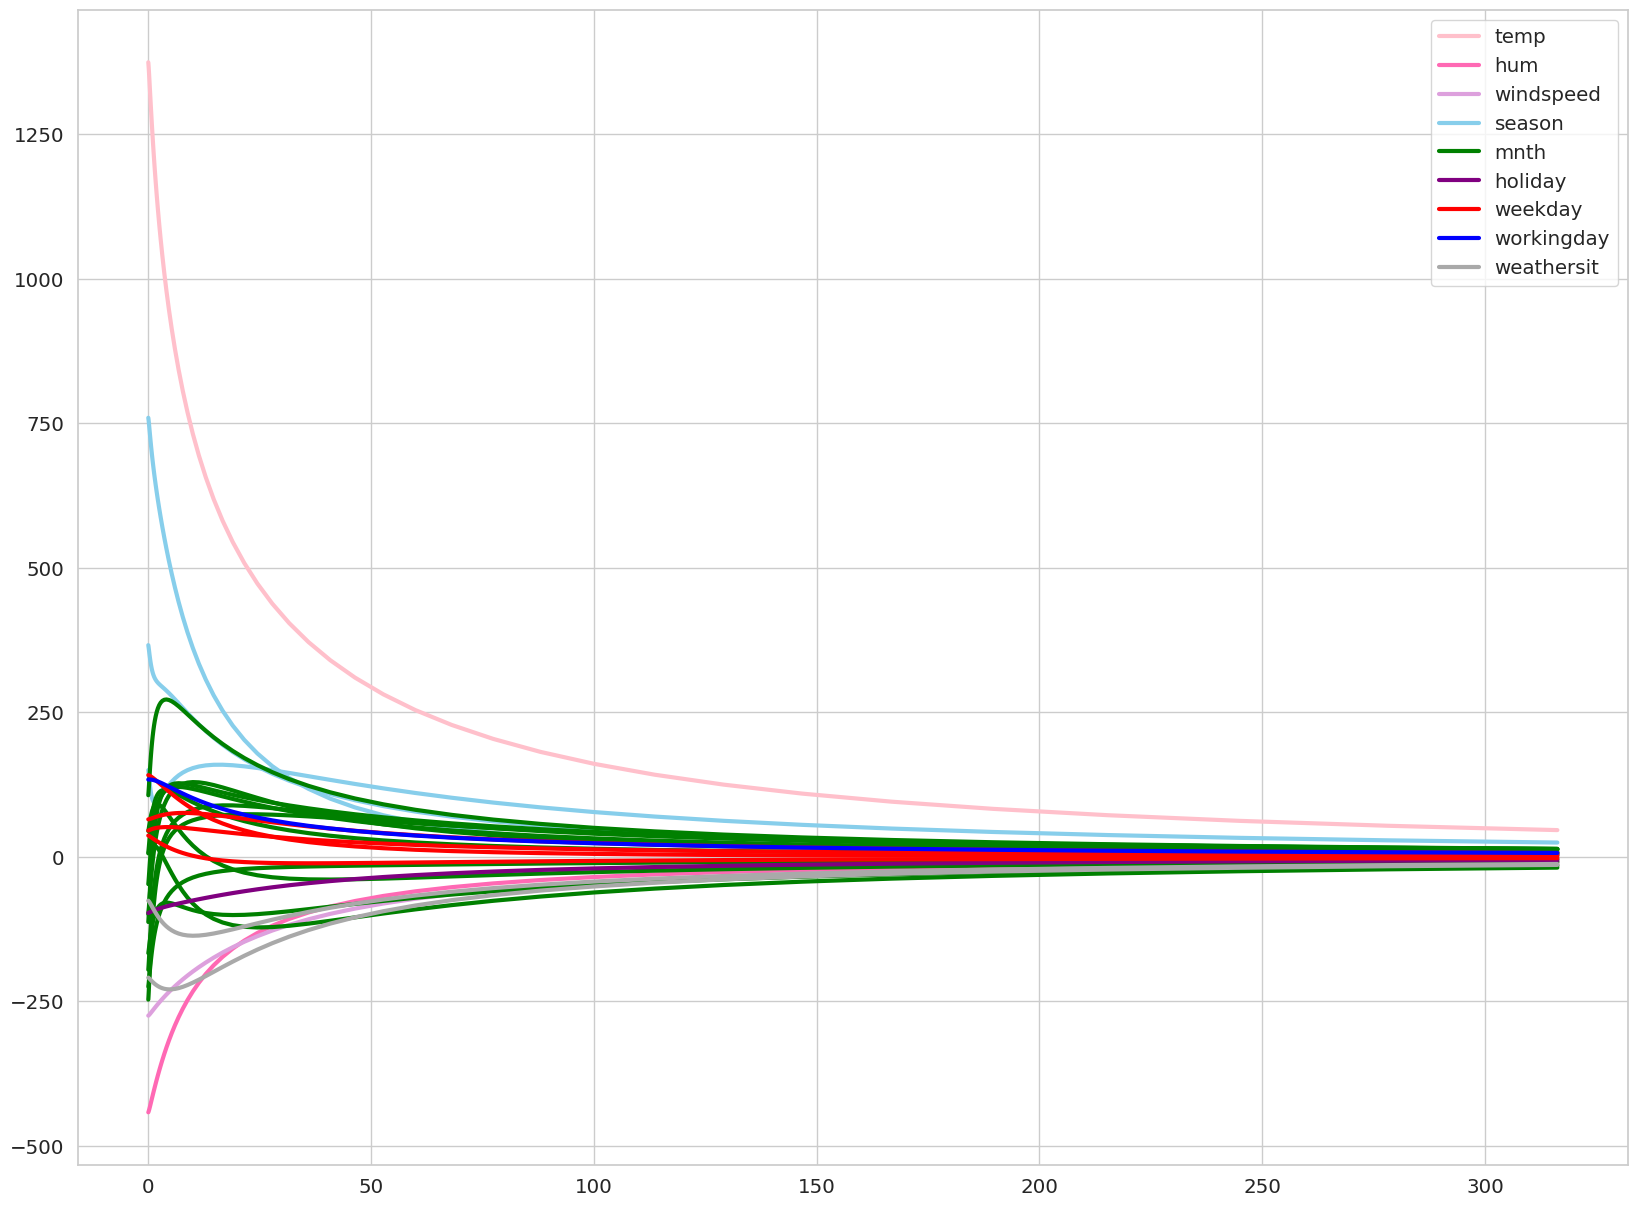

In [306]:
plt.figure(figsize=(20, 15))
coef = np.vstack([i.k for i in ans]).T

for i, key in enumerate(col.items()):
    feature, ind = key
    count = 0
    for j in ind:
        if count == 0:
            plt.plot(grid, coef[j], color[i], lw = 3, label = feature)
            count += 1
        else:
            plt.plot(grid, coef[j], color[i], lw = 3)
plt.legend ()
#plt.legend(line, ["temp", "hum", "windspeed", "season", "mnth", "holiday", "weekday", "workingday", "weathersit"])
plt.show()
    

Построим аналогичный график в логарифмическом маштабе

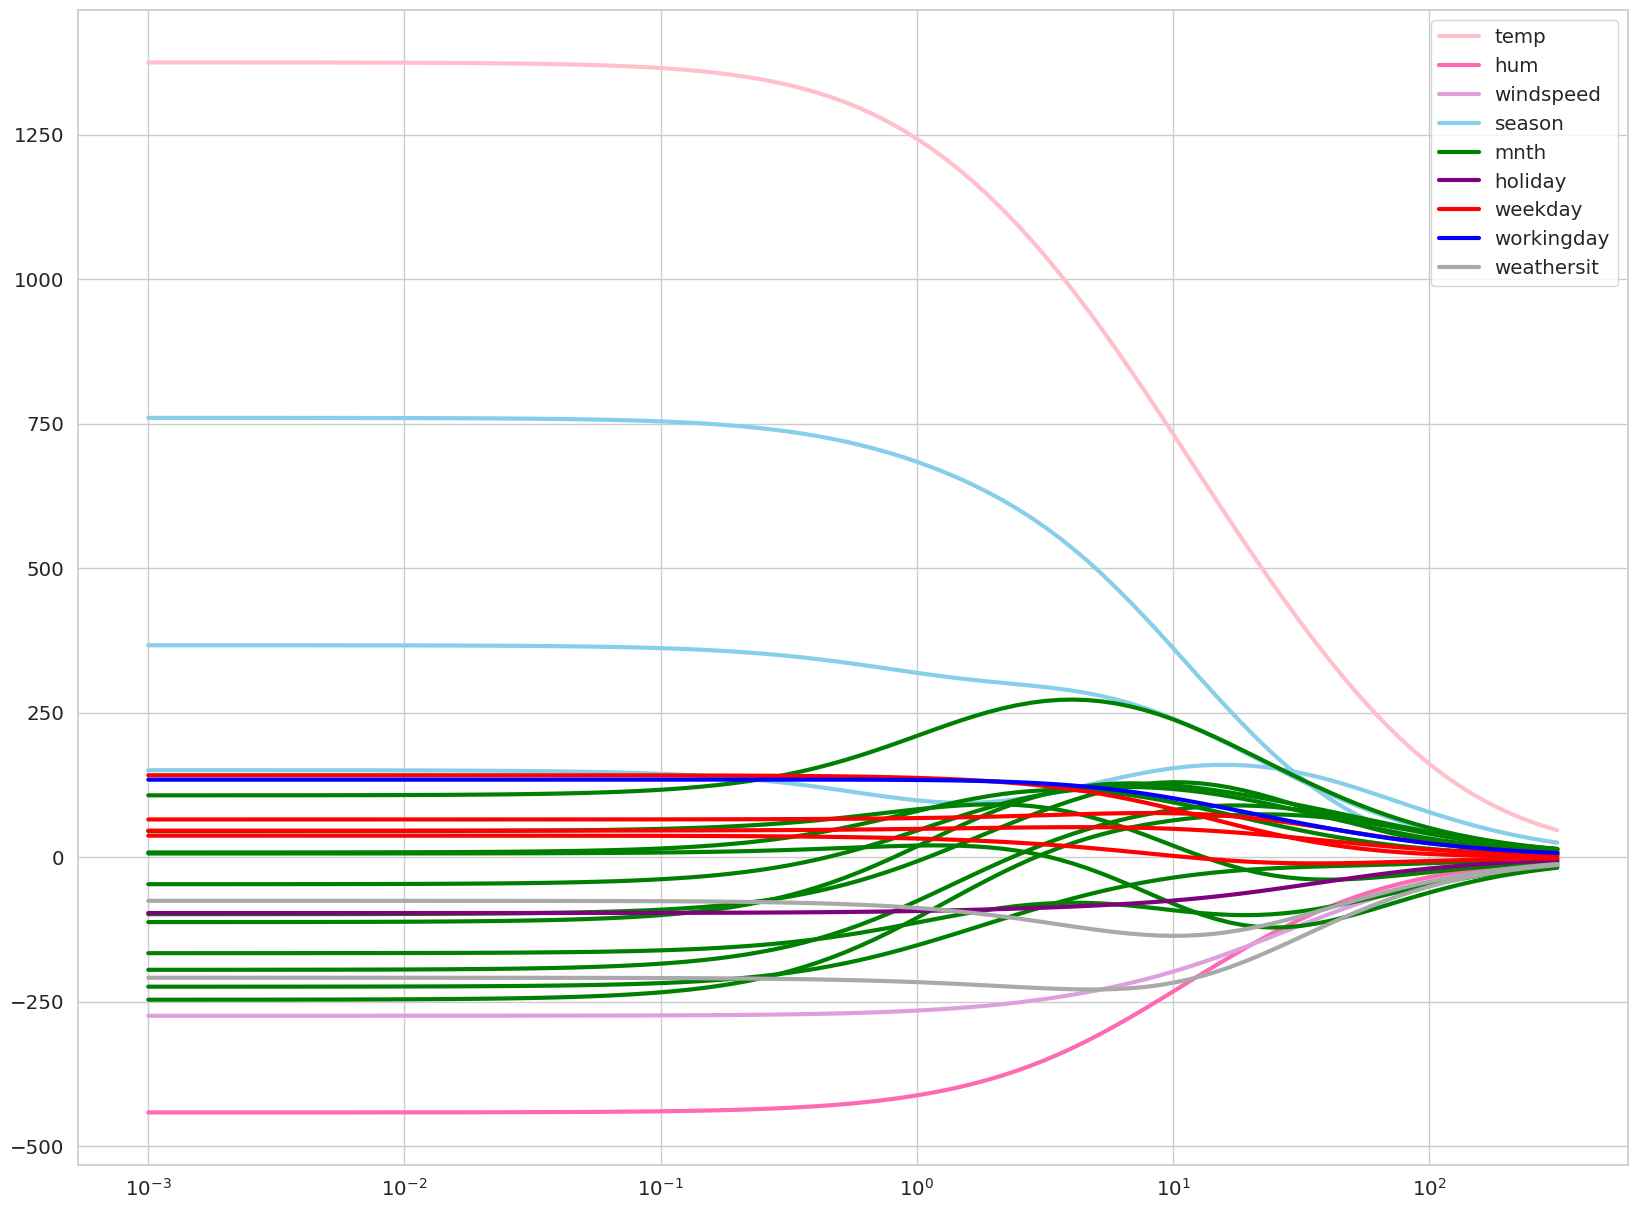

In [307]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot()
for i, key in enumerate(col.items()):
    feature, ind = key
    count = 0
    for j in ind:
        if count == 0:
            ax.plot(grid, coef[j], color[i], lw = 3, label = feature)
            count += 1
        else:
            ax.plot(grid, coef[j], color[i], lw = 3)
ax.set_xscale('log')
ax.legend()
plt.show()

Значения коэффициентов приближаются к нулю при увеличении $\lambda$ (скорее всего, это объясняеется тем, что чем выше коэффициент, тем выше штраф). Таким образом, коэффициенты сходятся к нулю. 

Выберим оптимальное значение гиперпараметра и посчитаем ошибку на тестовой выборке.
Для выбора гиперпараметра воспользуемся, полученной ошибкой RMSE на валидационных данных.

In [205]:
best_lambda = grid[np.argmin(vrmse)]
best_lambda

9.006280202112785

In [206]:
bm = RidgeRegression(best_lambda)
bm.fit(X_train, train[target_feature])
temp = bm.predict(X_test)

RMSE:

In [207]:
metrics.mean_squared_error(dtest[target_feature], temp) ** 0.5

1293.6901157609414

MAE:

In [208]:
metrics.mean_absolute_error(dtest[target_feature], temp)

1118.531690459857

In [209]:
mean_absolute_percentage_error(dtest[target_feature], temp)

28.049839476450018


**ВЫВОД:**

Графики показали, что модель на обучающихся данных получает ошибку намного ниже, чем на валидационных. Также исследование показало, что значения коэффициентов приближаются к нулю при увеличении $\lambda$ (- скорее всего, это объясняеется возрастанием штрафа при увеличении коэффициента). Таким образом, коэффициенты сходятся к нулю. После выбора наилучшего гипперпораметра значение ошибок gолучились: RMSE = 1293, MAE = 1118, MAPE = 28%.
 



Выберем некоторое начальное приближение оценок коэффициентов, например, в начале координат.

In [290]:
coef = np.zeros(len(X_train.T) + 1)

Реализуем процедуру стохастического градиентного спуска для поиска оценок коэффициентов в модели ridge-регрессии.

In [291]:
def gdt(coef: np.ndarray):
    batch_index = np.random.choice(len(X_train), 128) 
    tx = np.hstack([X_train[batch_index], np.ones((128, 1))]) 
    ty = train[target_feature].values[batch_index]
    
    return coef - 0.00001 * ((tx.T @ tx + best_lambda * np.eye(len(tx.T))) @ coef - tx.T @ ty)

Нарисуем графики зависимости значений метрик RMSE, MAE, MAPE от номера итерации для обучающей и валидационной выборок. 

In [292]:
trmse = []
vrmse = []
tmae = []
vmae = []
tmape = []
vmape = []

for step in range(400):    
    train_predictions = np.hstack([X_train, np.ones((len(X_train), 1))]) @ coef
    valid_predictions = np.hstack([X_val, np.ones((len(X_val), 1))]) @ coef
    
    trmse.append(metrics.mean_squared_error(train[target_feature], train_predictions) ** 0.5)
    vrmse.append(metrics.mean_squared_error(dval[target_feature], valid_predictions) ** 0.5)
    tmae.append(metrics.mean_absolute_error(train[target_feature], train_predictions))
    vmae.append(metrics.mean_absolute_error(dval[target_feature], valid_predictions))
    tmape.append(mean_absolute_percentage_error(train[target_feature], train_predictions))
    vmape.append(mean_absolute_percentage_error(dval[target_feature], valid_predictions))
    
    coef = gdt(coef)

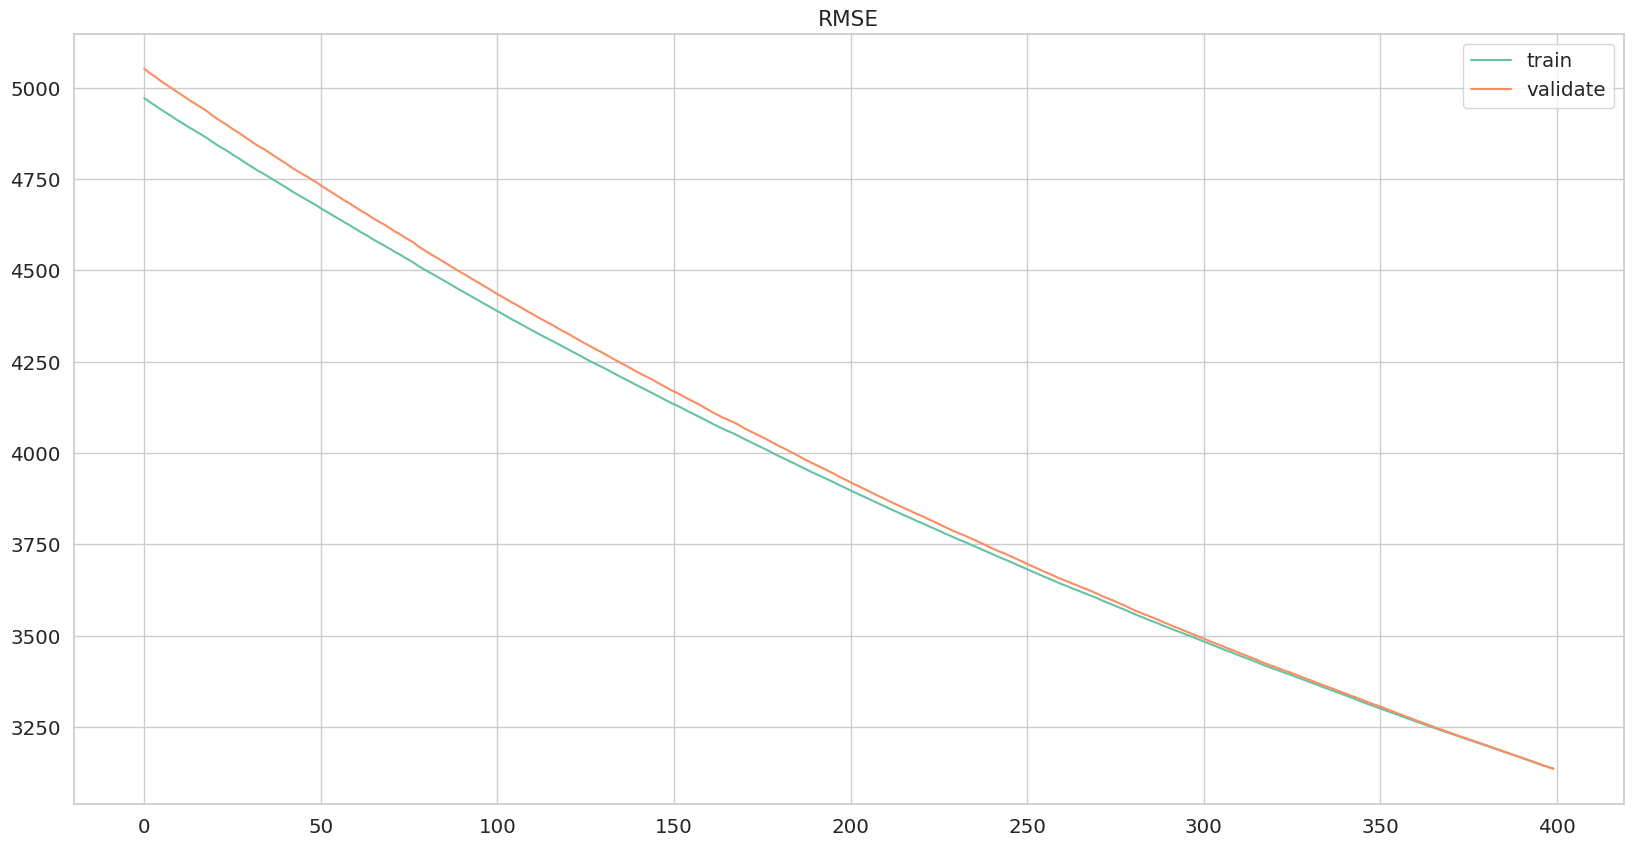

In [293]:
plt.figure(figsize=(20, 10))
plt.title("RMSE")

plt.plot(trmse)
plt.plot(vrmse)

plt.legend(["train", "validate"])

fig.tight_layout()

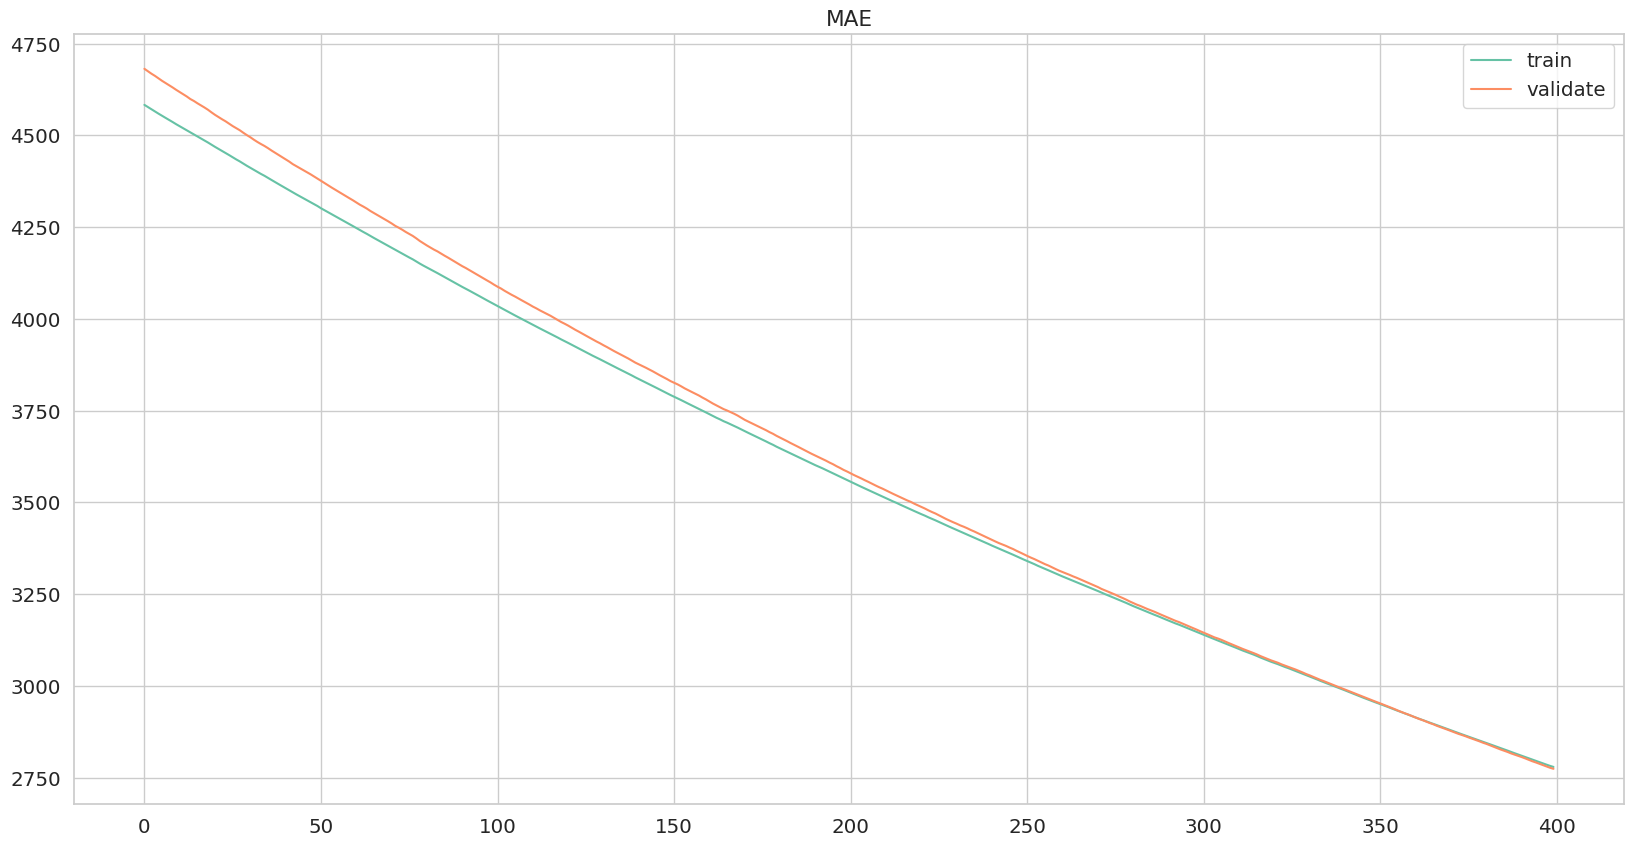

In [294]:
plt.figure(figsize=(20, 10))
plt.title("MAE")

plt.plot(tmae)
plt.plot(vmae)
plt.legend(["train", "validate"])

fig.tight_layout()

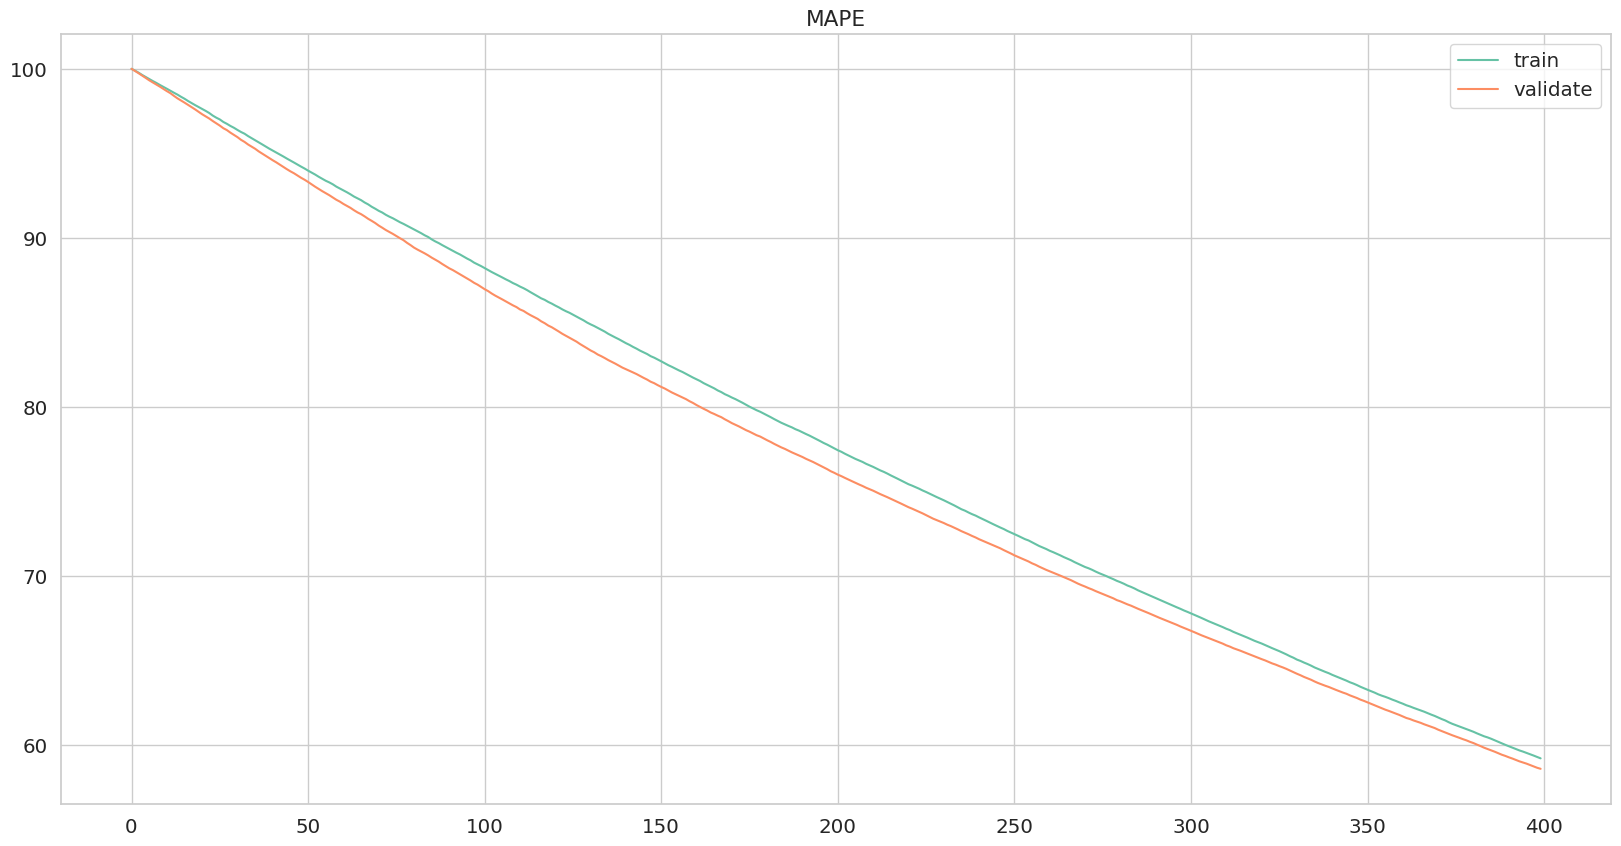

In [295]:
plt.figure(figsize=(20, 10))
plt.title("MAPE")

plt.plot(tmape)
plt.plot(vmape)

plt.legend(["train", "validate"])
plt.show()

В итоге потребовалось около 250 итераций.

Посчитаем ошибку на тестовой выборке.

In [216]:
temp = np.hstack([X_test, np.ones((len(X_test), 1))]) @ coef

RMSE:

In [217]:
metrics.mean_squared_error(dtest[target_feature], temp) ** 0.5

3515.8544798678463

MAE:

In [218]:
metrics.mean_absolute_error(dtest[target_feature], temp)

3184.725590580287

MAPE:

In [219]:
mean_absolute_percentage_error(dtest[target_feature], temp)

65.77838221137458



**ВЫВОД:** 


Значения ошибок в данном случае оказались выше, чем при подсчете ridge регрессии по формуле (например, сейчас MAPE = 65, а в предедущем задание MAPE = 28). В данном случе все усложняется тем, что необходимо подбирать размер батча и число итераций (при исследовании количества итераций было выявлено, что нужно совершить около 250 итераций) - если используемые параметры будут неудачно подобраны, то в результате мы получим большие значения ошибок.